In [1]:
import os
import h5py
import json
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import tqdm
tqdm.tqdm_notebook(range(0))

/users/amtseng/miniconda3/envs/tfmodisco/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


0it [00:00, ?it/s]

### Define paths/constants

In [2]:
mt_fold_path = "/users/amtseng/tfmodisco/results/model_stats/multitask_profile_finetune_stats.tsv"
st_fold_path = "/users/amtseng/tfmodisco/results/model_stats/singletask_profile_finetune_stats.tsv"
pred_perf_base_path = "/users/amtseng/tfmodisco/results/peak_predictions/"

input_length = 2114

In [3]:
# Chromosome split definition (i.e. test set chromosomes)
chrom_splits_json = "/users/amtseng/tfmodisco/data/processed/ENCODE/chrom_splits.json"
with open(chrom_splits_json, "r") as f:
    chrom_splits = json.load(f)
all_fold_test_chroms = {
    fold : chrom_splits[str(fold)]["test"] for fold in range(1, 11)
}

In [4]:
with open(mt_fold_path, "r") as f:
    tf_names = []
    mt_best_folds = {}  # {tf_name : fold}
    next(f)
    for line in f:
        tokens = line.split("\t")
        if tokens[0] not in tf_names:
            tf_names.append(tokens[0])
            mt_best_folds[tokens[0]] = int(tokens[2])
            
with open(st_fold_path, "r") as f:
    st_best_folds = {}  # {tf_name : [fold for each task]}
    next(f)
    for line in f:
        tokens = line.split("\t")
        if tokens[0] not in st_best_folds:
            st_best_folds[tokens[0]] = []
        st_best_folds[tokens[0]].append(int(tokens[2]))
        
num_tasks = {tf_name : len(st_best_folds[tf_name]) for tf_name in tf_names}

In [5]:
# Import peaks
task_coords = {}  # {tf_name : [peak table for each task]}
for tf_name in tf_names:
    files_spec_json = "/users/amtseng/tfmodisco/data/processed/ENCODE/config/{0}/{0}_training_paths.json".format(tf_name)
    with open(files_spec_json, "r") as f:
        files_spec = json.load(f)
    assert len(files_spec["peak_beds"]) == num_tasks[tf_name]
    
    task_coords[tf_name] = []
    for peak_bed_path in files_spec["peak_beds"]:
        table = pd.read_csv(
            peak_bed_path, sep="\t", header=None,  # Infer compression
            names=[
                "chrom", "peak_start", "peak_end", "name", "score",
                "strand", "signal", "pval", "qval", "summit_offset"
            ]
        )
        # Add summit location column:
        table["summit"] = table["peak_start"] + table["summit_offset"]

        # Add start and end columns, at proper length
        table["start"] = table["summit"] - (input_length // 2)
        table["end"] = table["start"] + input_length

        task_coords[tf_name].append(table[["chrom", "start", "end"]])

### Helper functions

In [6]:
def subset_coord_inds(superset_coords, subset_coords):
    """
    Both `superset_coords` and `subset_coords` are Pandas DataFrames of
    coordinates. This will return the indices within `superset_coords`
    (indices being the 0-indexed row numbers) that correspond to the
    coordinates in `subset_coords`. Returns a sorted NumPy array of indices.
    Note that if there are duplicates in either set of coordinates, they
    will be dropped (i.e. the returned indices will be unique).
    """
    inds = superset_coords.reset_index().drop_duplicates(["chrom", "start", "end"]).merge(
        subset_coords.reset_index(), on=["chrom", "start", "end"]
    ).sort_values("index_y")["index_x"].values
    return np.unique(inds)

In [7]:
def filter_coords_by_chroms(coords, chroms):
    """
    Given a Pandas DataFrame of coordinates (column names "chrom", "start",
    and "end"), filters for the chromosomes in `chroms`
    """
    return coords[coords["chrom"].isin(chroms)]

In [8]:
def extract_counts(pred_perf_path, coord_sets=None, task_inds=None):
    """
    Extracts the set of all true and predicted log counts from a saved
    predictions/performance HDF5 file. Returns N x T x 2 arrays for the
    true and predicted log counts, respectively. `N` is all peaks in the
    file. If specified, filters for coordinates that are in `coord_sets`.
    `coord_sets` is a list of coordinate DataFrames, and a set of counts will
    be fetched for each table of coordinates provided. Otherwise, will simply
    return all coordinates available. If `task_inds` is specified, it must be
    a list of indices parallel to `coord_sets`. For each coordinate set, the
    counts extracted will be for that task index only. If unspecified, all
    tasks are retained for each coordinate set.
    """
    result = {}
    
    reader = h5py.File(pred_perf_path, "r")
    coord_reader = reader["coords"]
    pred_reader = reader["predictions"]
    perf_reader = reader["performance"]
    
    # First, get the set of indices within the HDF5 predictions/performance that
    # correspond to the given coordinate sets
    if coord_sets is None:
        subset_inds = [np.arange(perf_reader["nll"].shape[0])]  # The entire vector
    else:
        # Import the DataFrame of coordinates in this HDF5
        pred_perf_coords = pd.DataFrame(
            data={
                "chrom": coord_reader["coords_chrom"][:].astype(str),
                "start": coord_reader["coords_start"][:],
                "end": coord_reader["coords_end"][:]
            }
        )
        subset_inds = [
            subset_coord_inds(pred_perf_coords, coord_set)
            for coord_set in coord_sets
        ]
    
    # If we didn't specify a task index for each coordinate set, just use
    # all tasks; either way, let's get each set of task indices into a
    # NumPy array form
    if task_inds is None:
        task_inds = [np.arange(perf_reader["nll"].shape[1]) for _ in range(len(subset_inds))]
    else:
        task_inds = [np.array([i]) for i in task_inds]
        
    # Extract the count values
    log_true_counts, log_pred_counts = [], []
    if coord_sets is None:
        log_true_counts.append(np.ravel(np.log(pred_reader["true_counts"][:] + 1)))
        log_pred_counts.append(np.ravel(pred_reader["log_pred_counts"][:]))
    else:
        for i in range(len(subset_inds)):
            subset = subset_inds[i]
            tasks = task_inds[i]
            log_true_counts.append(np.ravel(np.log(pred_reader["true_counts"][subset][:, tasks] + 1)))
            log_pred_counts.append(np.ravel(pred_reader["log_pred_counts"][subset][:, tasks]))
        
    reader.close()
        
    log_true_counts = np.concatenate(log_true_counts)
    log_pred_counts = np.concatenate(log_pred_counts)
    return log_true_counts, log_pred_counts

### Import data/metrics

In [9]:
mt_all_fold_count_corrs = {}  # {tf_name : {fold: [(pears, spear) for each task]}
st_all_fold_count_corrs = {}  # {tf_name : {fold: [(pears, spear) for each task]}
mt_best_fold_count_corrs = {}  # {tf_name : [(pears, spear) for each task, on the best fold]}
st_best_fold_count_corrs = {}  # {tf_name : [(pears, spear) for each task, on each best fold]}

for tf_name in tf_names:
    mt_all_fold_count_corrs[tf_name] = {}
    st_all_fold_count_corrs[tf_name] = {}
    for fold in range(1, 11):
        print("Extracting:", tf_name, fold)
        
        # Multi-task all folds
        pred_perf_path = os.path.join(
            pred_perf_base_path,
            "multitask_profile",
            "%s_multitask_profile_fold%d" % (tf_name, fold),
            "%s_multitask_profile_fold%d_pred_perf.h5" % (tf_name, fold)
        )
        corrs = []
        for task_index in tqdm.notebook.trange(num_tasks[tf_name]):
            log_true_counts, log_pred_counts = extract_counts(
                pred_perf_path,
                [filter_coords_by_chroms(task_coords[tf_name][task_index], all_fold_test_chroms[fold])],
                [task_index]
            )
            corrs.append(
                (
                    scipy.stats.pearsonr(np.ravel(log_true_counts), np.ravel(log_pred_counts))[0],
                    scipy.stats.spearmanr(np.ravel(log_true_counts), np.ravel(log_pred_counts))[0],
                )
            )
        mt_all_fold_count_corrs[tf_name][fold] = corrs
            
        # Single-task all folds
        corrs = []
        for task_index in tqdm.notebook.trange(num_tasks[tf_name]):
            pred_perf_path = os.path.join(
                pred_perf_base_path,
                "singletask_profile",
                "%s_singletask_profile_fold%d" % (tf_name, fold),
                "task_%d" % task_index,
                "%s_singletask_profile_task%d_fold%d_pred_perf.h5" % (tf_name, task_index, fold)
            )
            log_true_counts, log_pred_counts = extract_counts(
                pred_perf_path,
                [filter_coords_by_chroms(task_coords[tf_name][task_index], all_fold_test_chroms[fold])]
            )
            corrs.append(
                (
                    scipy.stats.pearsonr(np.ravel(log_true_counts), np.ravel(log_pred_counts))[0],
                    scipy.stats.spearmanr(np.ravel(log_true_counts), np.ravel(log_pred_counts))[0],
                )
            )
        st_all_fold_count_corrs[tf_name][fold] = corrs
    
    print("Extracting:", tf_name, "FT")
        
    # Multi-task fine-tune
    fold = mt_best_folds[tf_name]
    pred_perf_path = os.path.join(
        pred_perf_base_path,
        "multitask_profile_finetune",
        "%s_multitask_profile_finetune_fold%d" % (tf_name, fold),
        "%s_multitask_profile_finetune_fold%d_pred_perf.h5" % (tf_name, fold)
    )
    corrs = []
    for task_index in tqdm.notebook.trange(num_tasks[tf_name]):
        log_true_counts, log_pred_counts = extract_counts(
            pred_perf_path,
            [filter_coords_by_chroms(task_coords[tf_name][task_index], all_fold_test_chroms[fold])],
            [task_index]
        )
        corrs.append(
            (
                scipy.stats.pearsonr(np.ravel(log_true_counts), np.ravel(log_pred_counts))[0],
                scipy.stats.spearmanr(np.ravel(log_true_counts), np.ravel(log_pred_counts))[0],
            )
        )
    mt_best_fold_count_corrs[tf_name] = corrs

    # Single-task fine-tune
    corrs = []
    for task_index in tqdm.notebook.trange(num_tasks[tf_name]):
        fold = st_best_folds[tf_name][task_index]
        pred_perf_path = os.path.join(
            pred_perf_base_path,
            "singletask_profile_finetune",
            "%s_singletask_profile_finetune_fold%d" % (tf_name, fold),
            "task_%d" % task_index,
            "%s_singletask_profile_finetune_task%d_fold%d_pred_perf.h5" % (tf_name, task_index, fold)
        )
        log_true_counts, log_pred_counts = extract_counts(
            pred_perf_path,
            [filter_coords_by_chroms(task_coords[tf_name][task_index], all_fold_test_chroms[fold])]
        )
        corrs.append(
            (
                scipy.stats.pearsonr(np.ravel(log_true_counts), np.ravel(log_pred_counts))[0],
                scipy.stats.spearmanr(np.ravel(log_true_counts), np.ravel(log_pred_counts))[0],
            )
        )
    st_best_fold_count_corrs[tf_name] = corrs

Extracting: E2F6 1



Extracting: E2F6 2



Extracting: E2F6 3



Extracting: E2F6 4



Extracting: E2F6 5



Extracting: E2F6 6



Extracting: E2F6 7



Extracting: E2F6 8



Extracting: E2F6 9



Extracting: E2F6 10



Extracting: E2F6 FT



Extracting: FOXA2 1



Extracting: FOXA2 2



Extracting: FOXA2 3



Extracting: FOXA2 4



Extracting: FOXA2 5



Extracting: FOXA2 6



Extracting: FOXA2 7



Extracting: FOXA2 8



Extracting: FOXA2 9



Extracting: FOXA2 10



Extracting: FOXA2 FT



Extracting: SPI1 1



Extracting: SPI1 2



Extracting: SPI1 3



Extracting: SPI1 4



Extracting: SPI1 5



Extracting: SPI1 6



Extracting: SPI1 7



Extracting: SPI1 8



Extracting: SPI1 9



Extracting: SPI1 10



Extracting: SPI1 FT



Extracting: CEBPB 1



Extracting: CEBPB 2



Extracting: CEBPB 3



Extracting: CEBPB 4



Extracting: CEBPB 5



Extracting: CEBPB 6



Extracting: CEBPB 7



Extracting: CEBPB 8



Extracting: CEBPB 9



Extracting: CEBPB 10



Extracting: CEBPB FT



Extracting: MAX 1



Extracting: MAX 2



Extracting: MAX 3



Extracting: MAX 4



Extracting: MAX 5



Extracting: MAX 6



Extracting: MAX 7



Extracting: MAX 8



Extracting: MAX 9



Extracting: MAX 10



Extracting: MAX FT



Extracting: GABPA 1



Extracting: GABPA 2



Extracting: GABPA 3



Extracting: GABPA 4



Extracting: GABPA 5



Extracting: GABPA 6



Extracting: GABPA 7



Extracting: GABPA 8



Extracting: GABPA 9



Extracting: GABPA 10



Extracting: GABPA FT



Extracting: MAFK 1



Extracting: MAFK 2



Extracting: MAFK 3



Extracting: MAFK 4



Extracting: MAFK 5



Extracting: MAFK 6



Extracting: MAFK 7



Extracting: MAFK 8



Extracting: MAFK 9



Extracting: MAFK 10



Extracting: MAFK FT



Extracting: JUND 1



Extracting: JUND 2



Extracting: JUND 3



Extracting: JUND 4



Extracting: JUND 5



Extracting: JUND 6



Extracting: JUND 7



Extracting: JUND 8



Extracting: JUND 9



Extracting: JUND 10



Extracting: JUND FT



Extracting: NR3C1-reddytime 1



Extracting: NR3C1-reddytime 2



Extracting: NR3C1-reddytime 3



Extracting: NR3C1-reddytime 4



Extracting: NR3C1-reddytime 5



Extracting: NR3C1-reddytime 6



Extracting: NR3C1-reddytime 7



Extracting: NR3C1-reddytime 8



Extracting: NR3C1-reddytime 9



Extracting: NR3C1-reddytime 10



Extracting: NR3C1-reddytime FT



Extracting: REST 1



Extracting: REST 2



Extracting: REST 3



Extracting: REST 4



Extracting: REST 5



Extracting: REST 6



Extracting: REST 7



Extracting: REST 8



Extracting: REST 9



Extracting: REST 10



Extracting: REST FT


### Show statistics

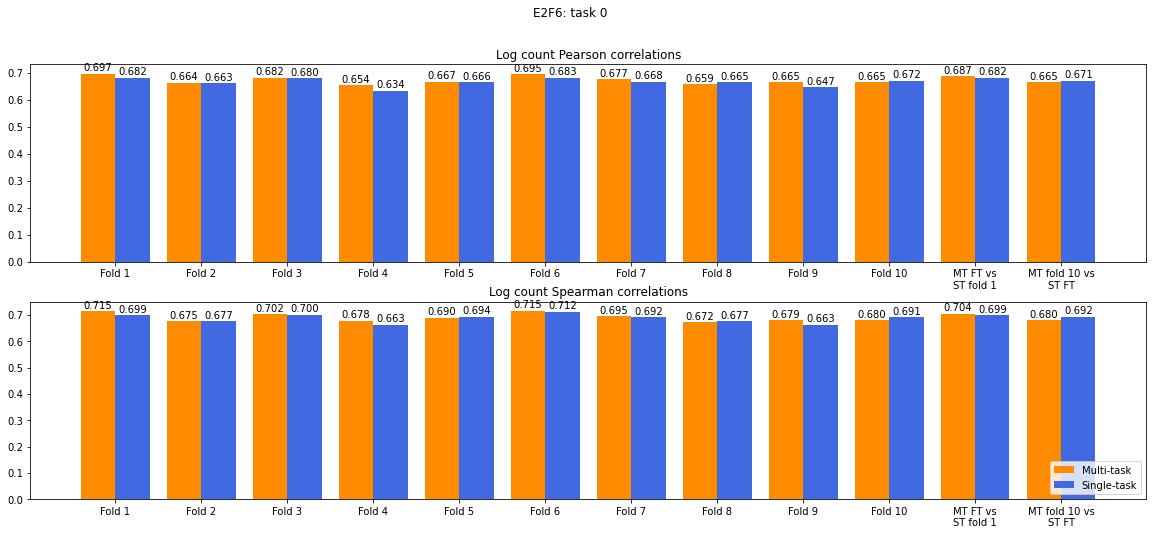

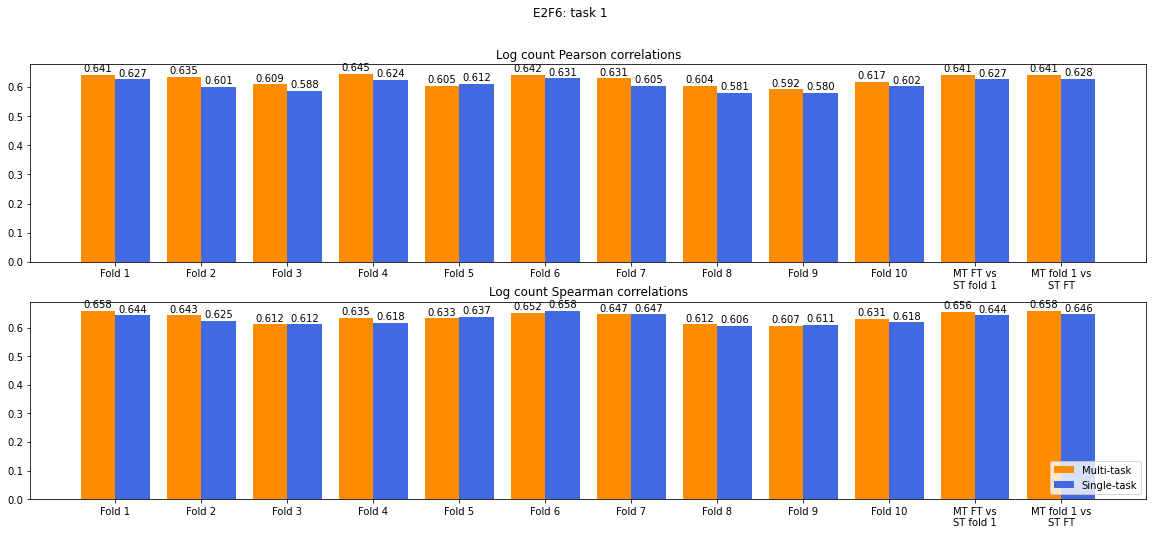

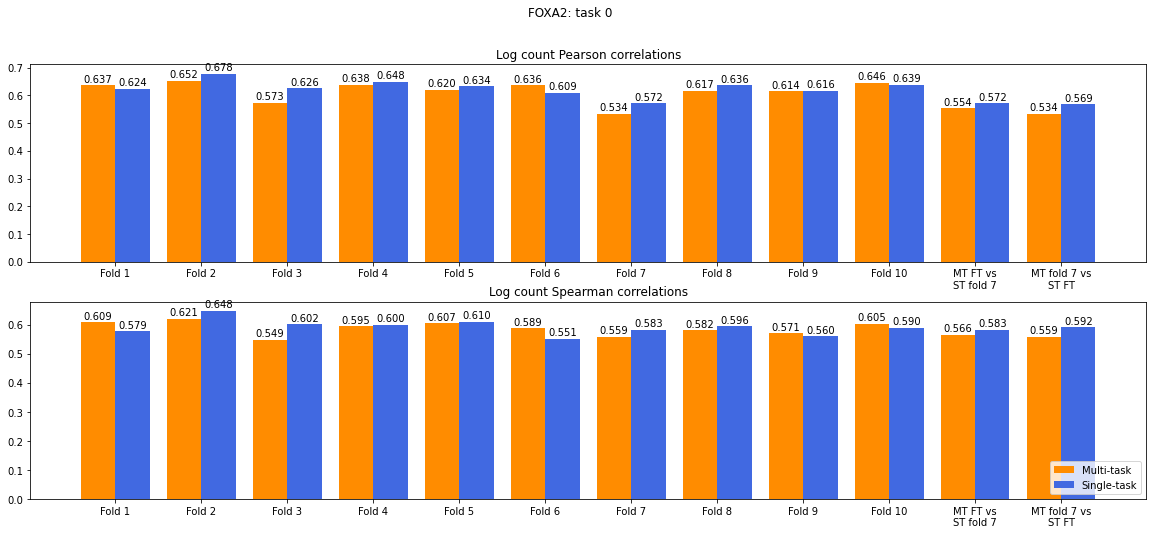

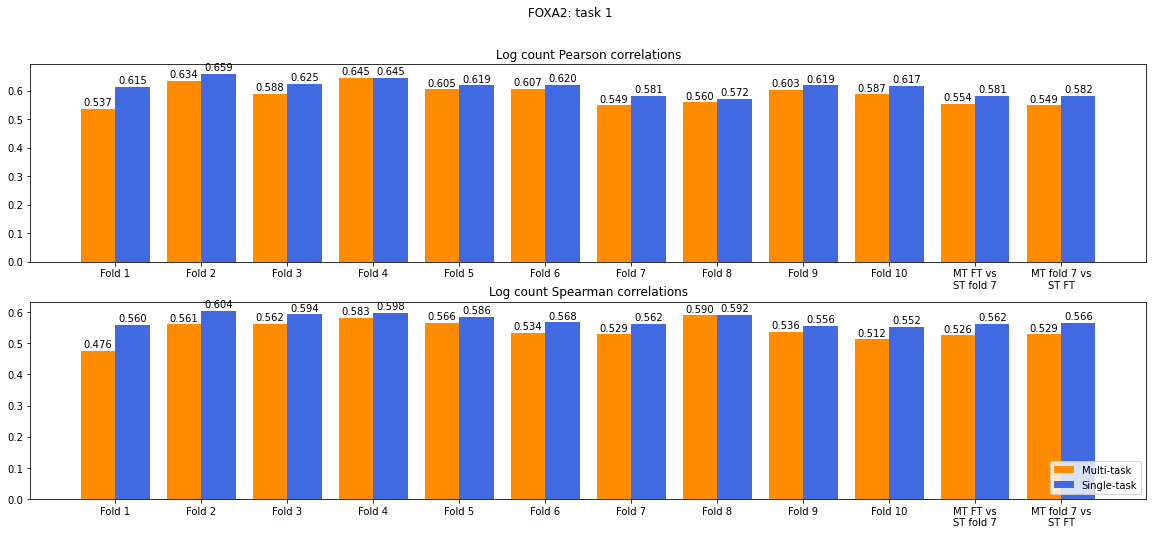

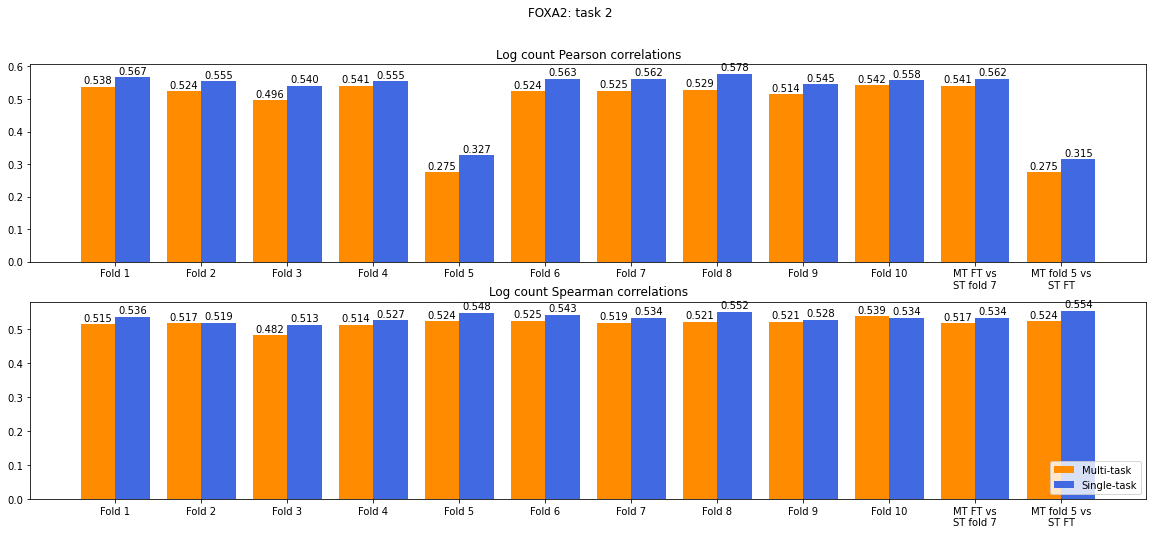

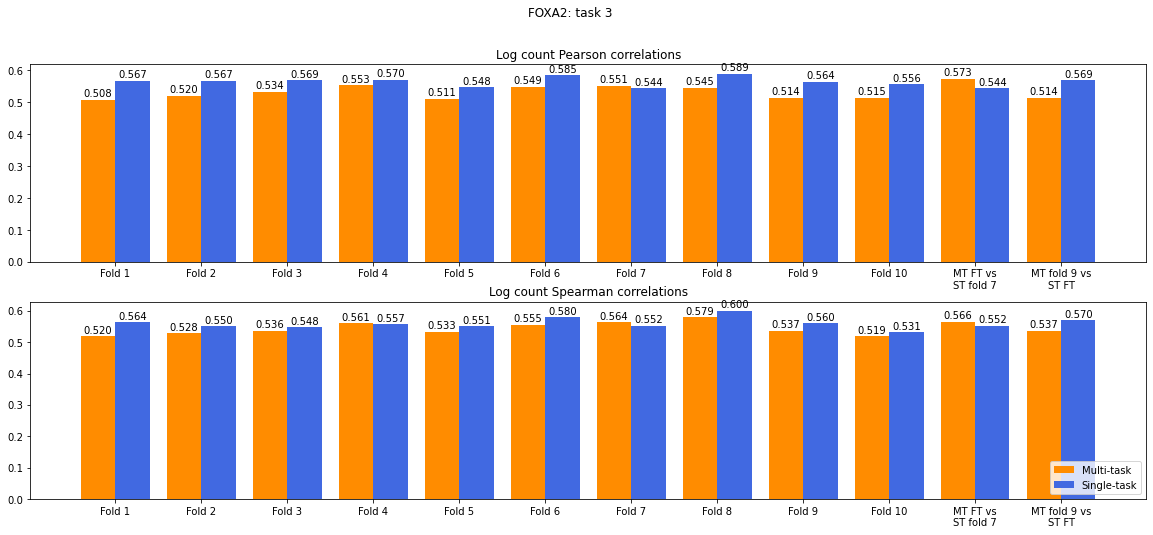

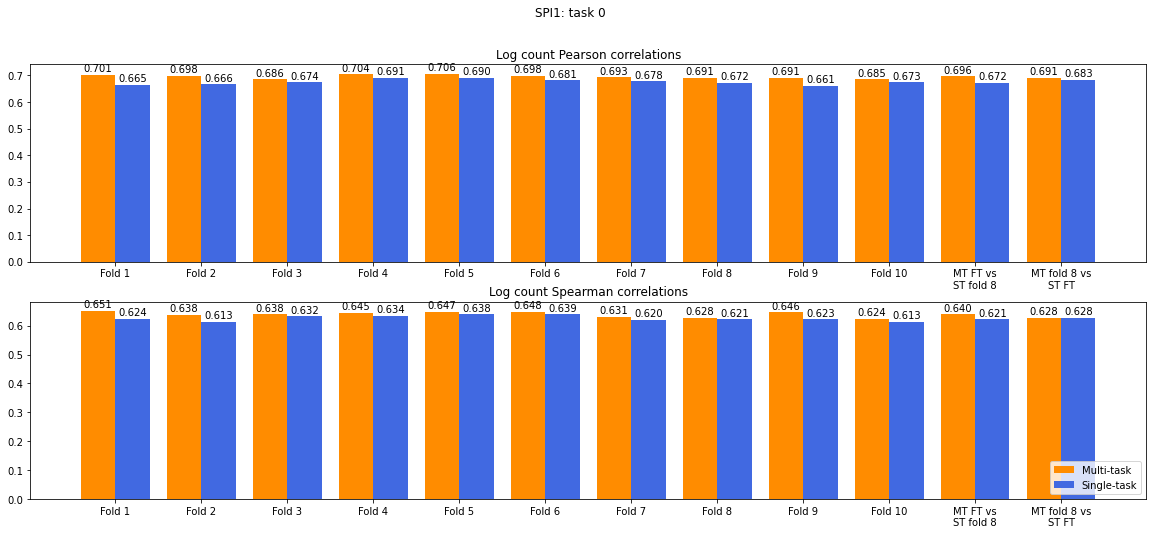

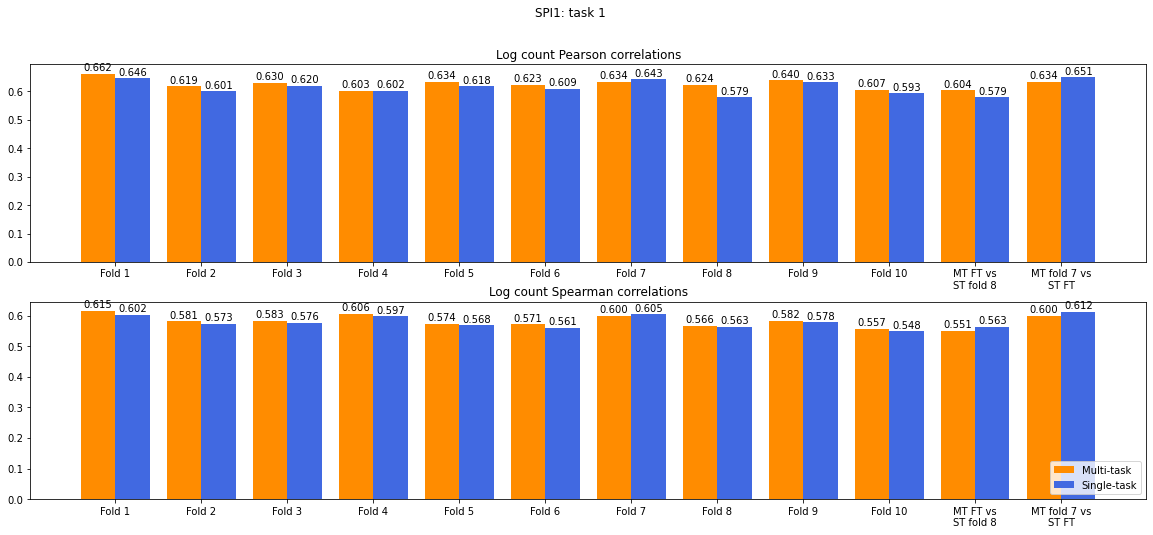

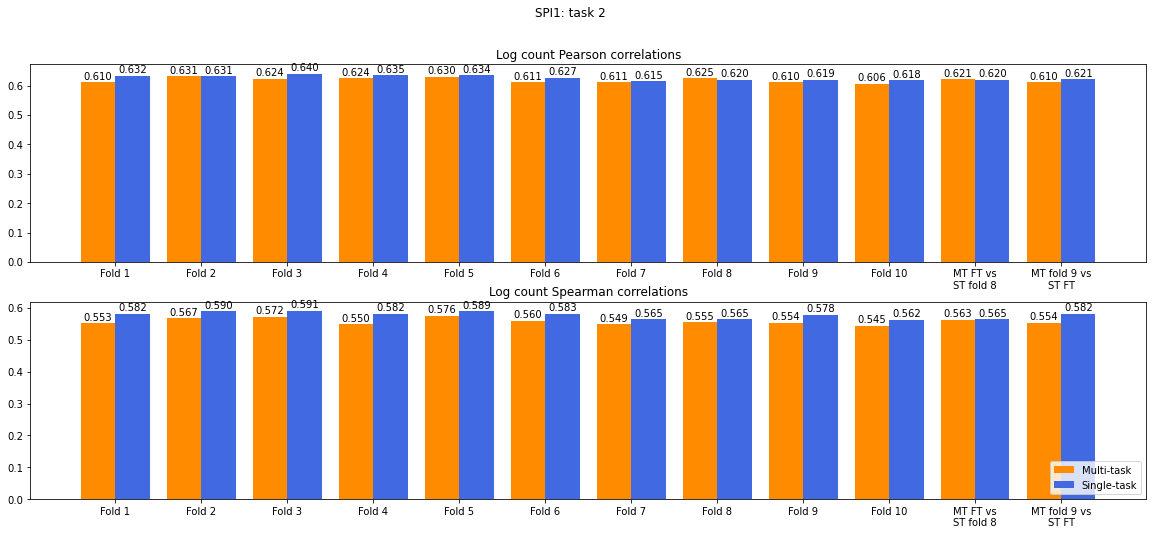

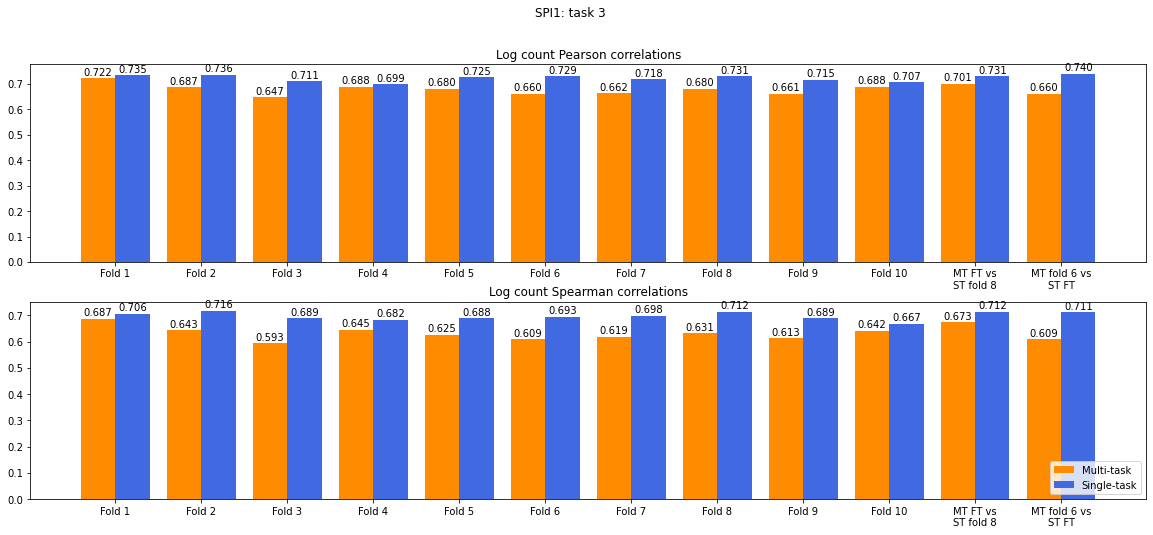

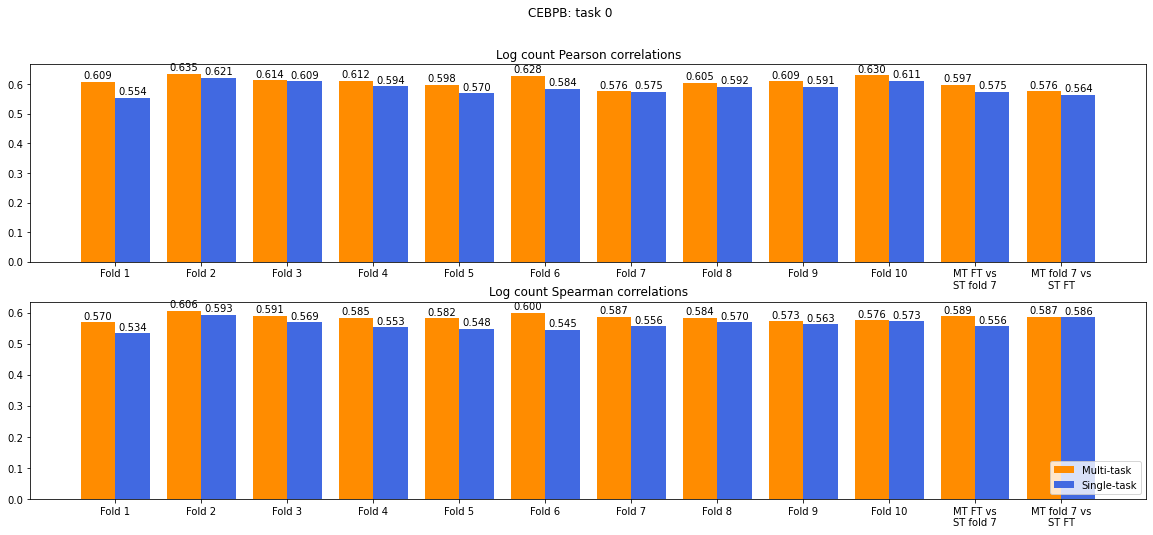

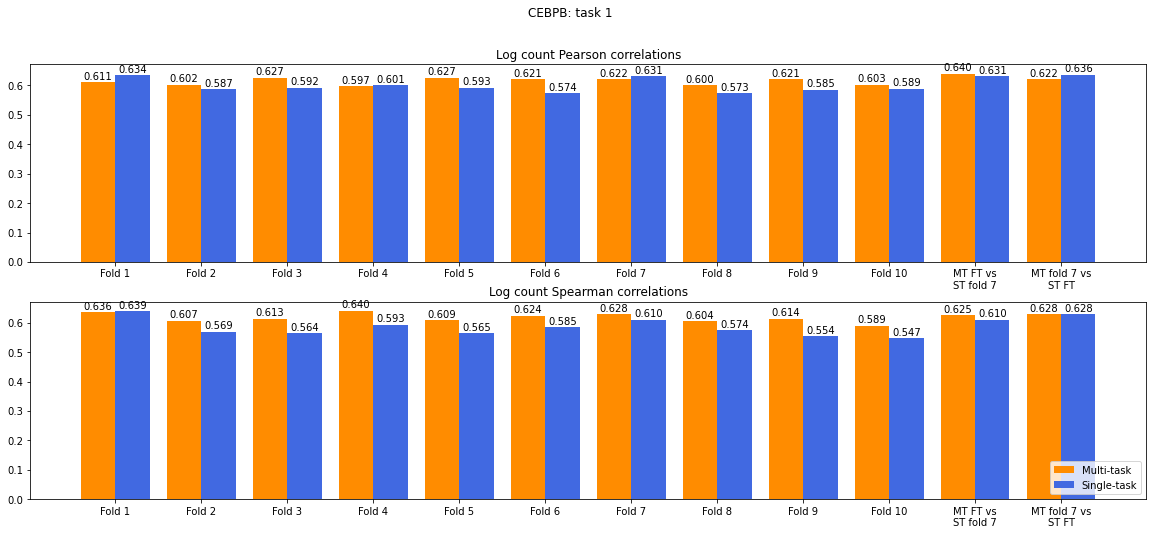

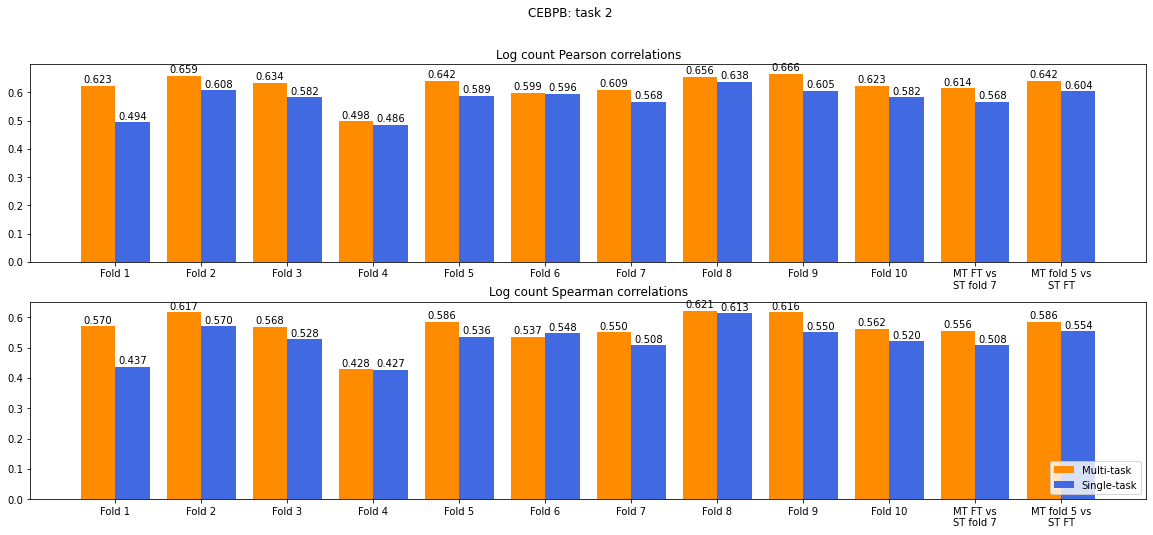

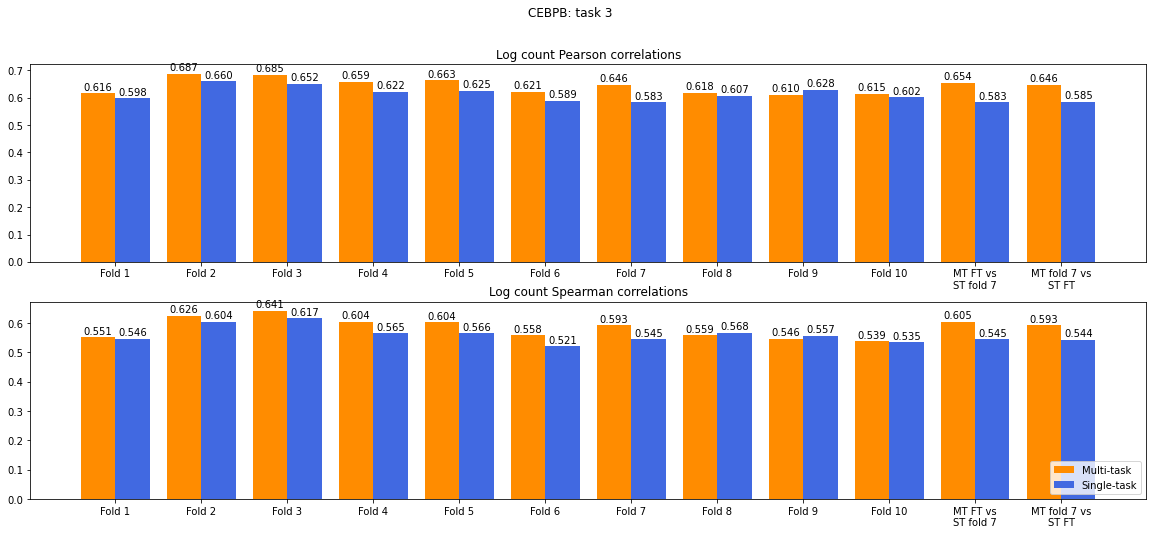

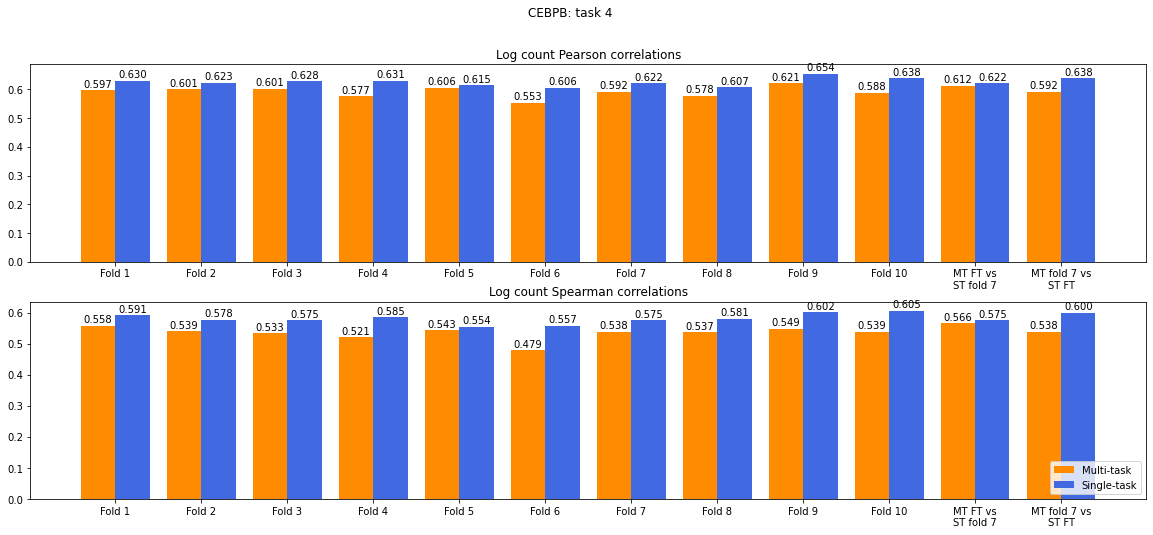

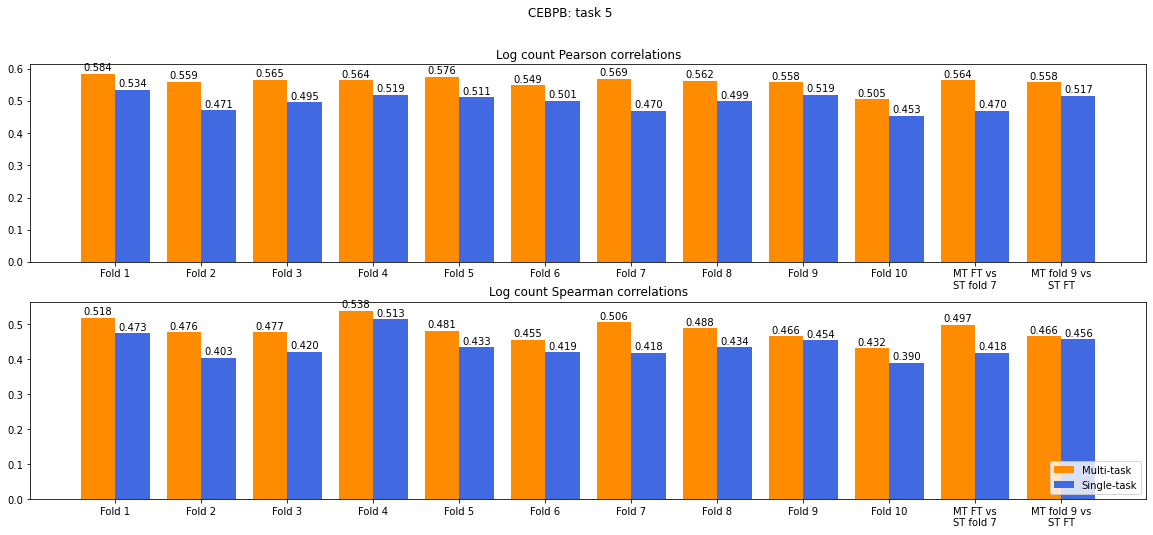

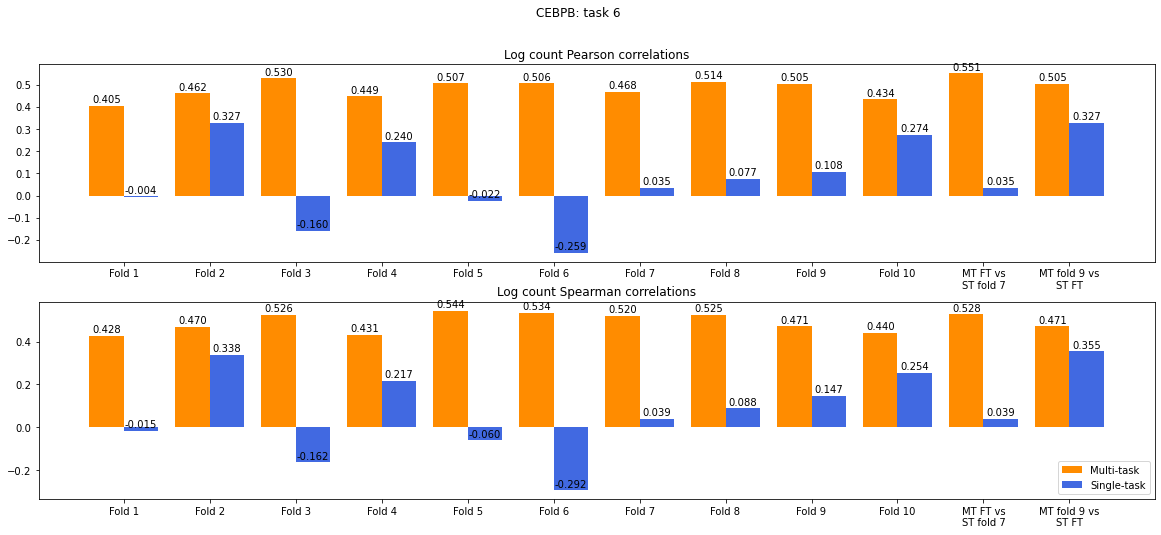

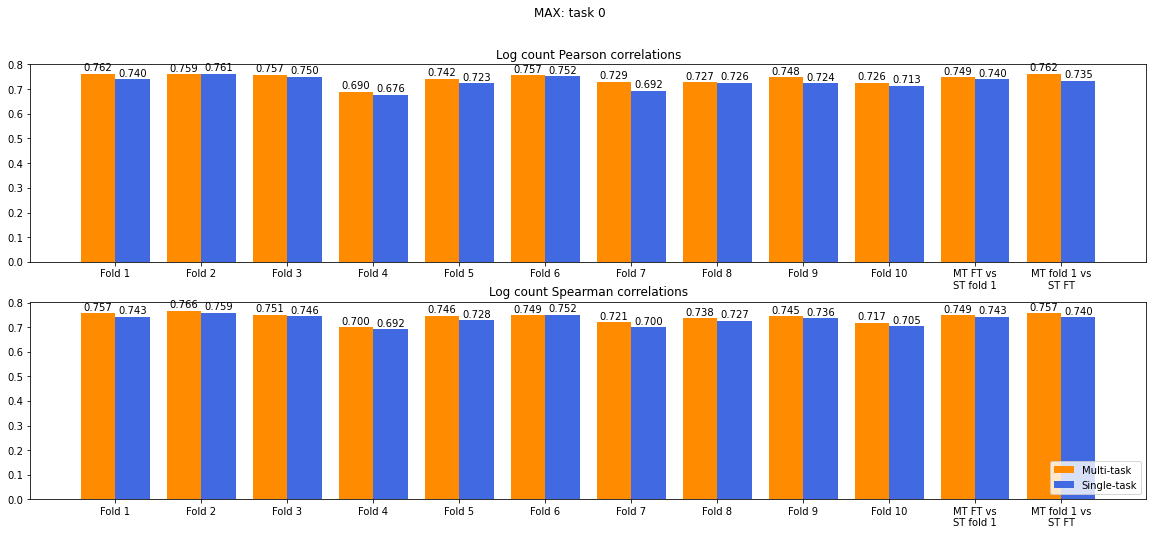

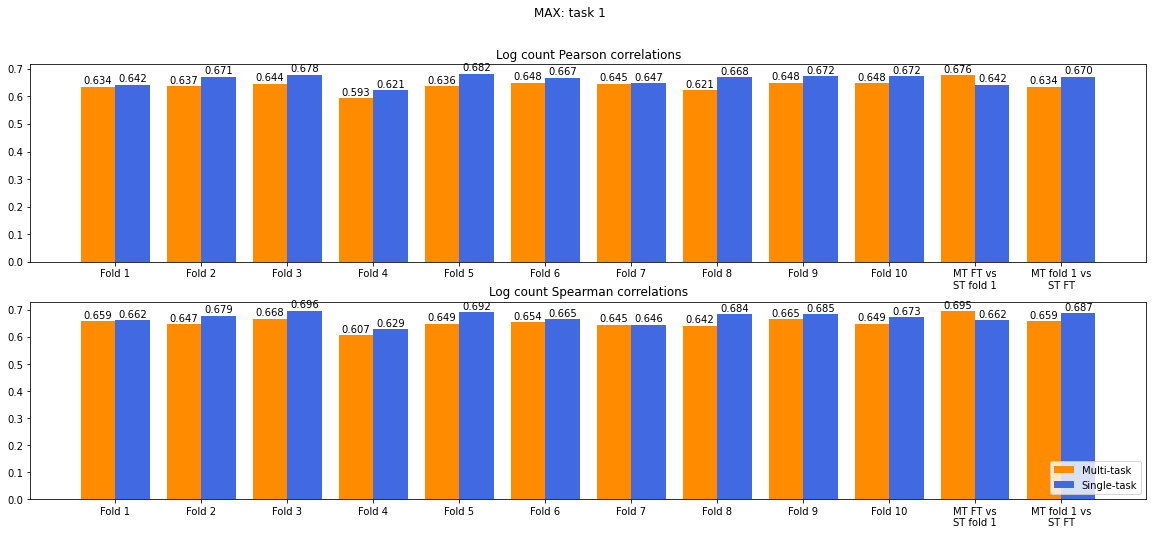

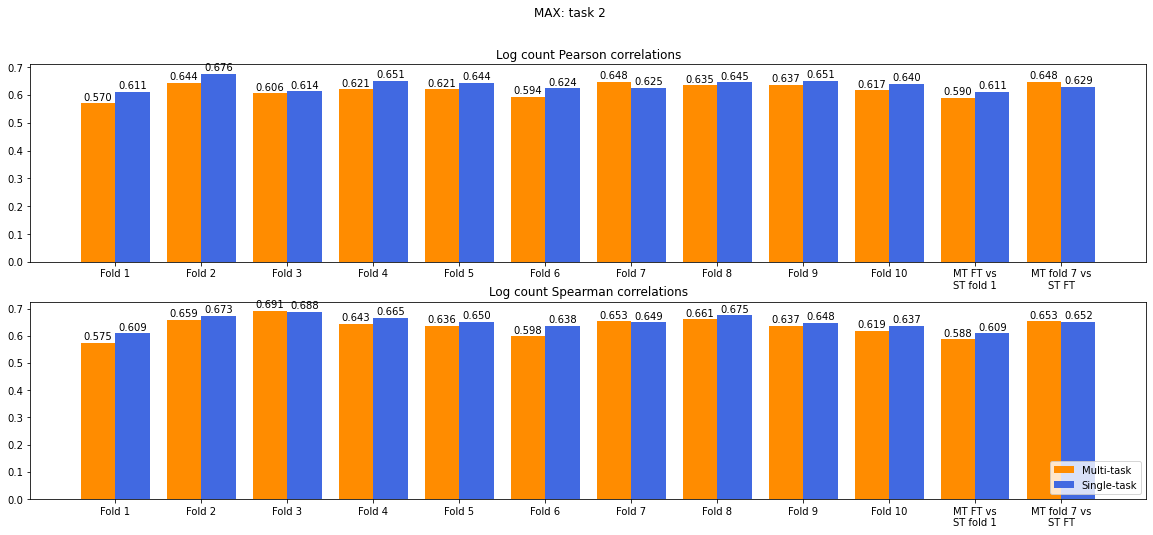

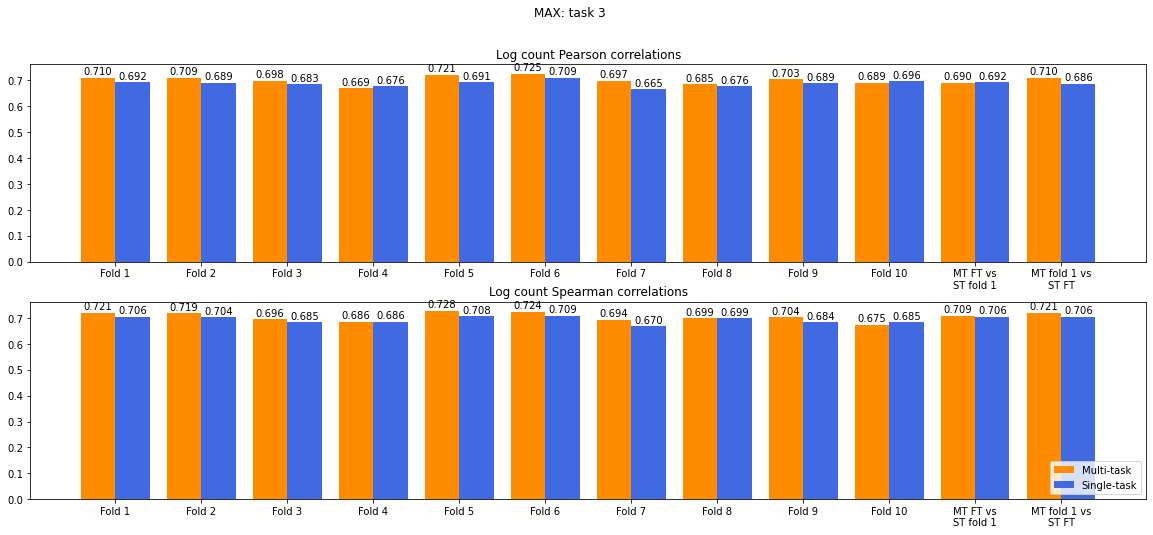

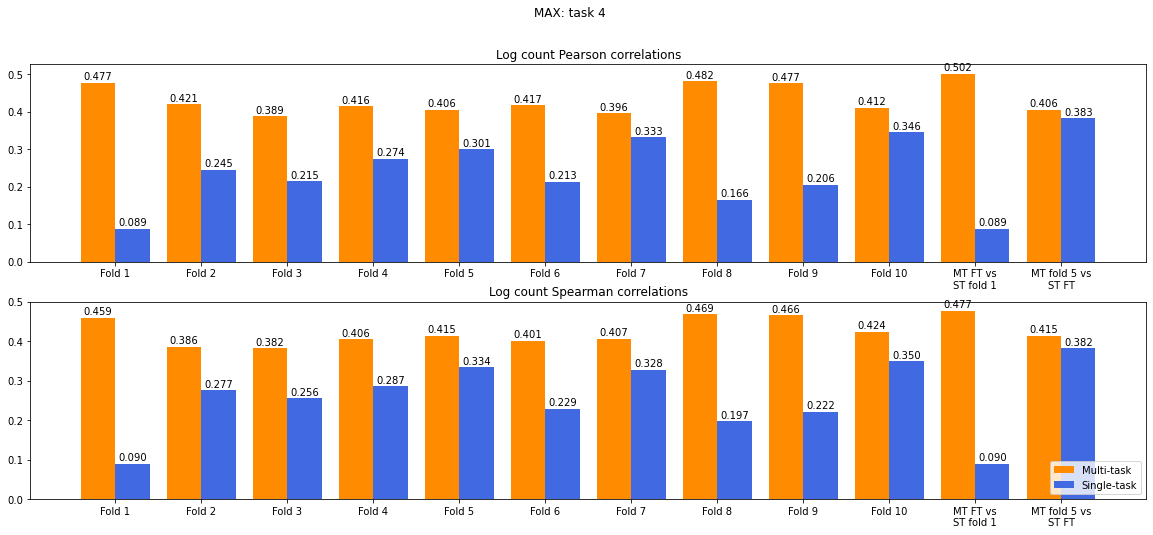

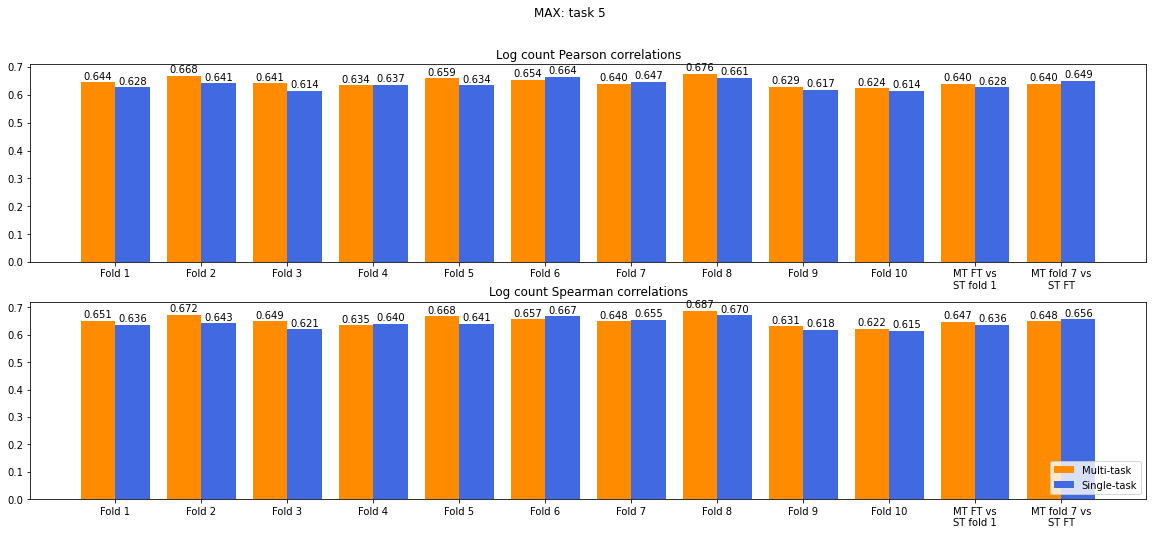

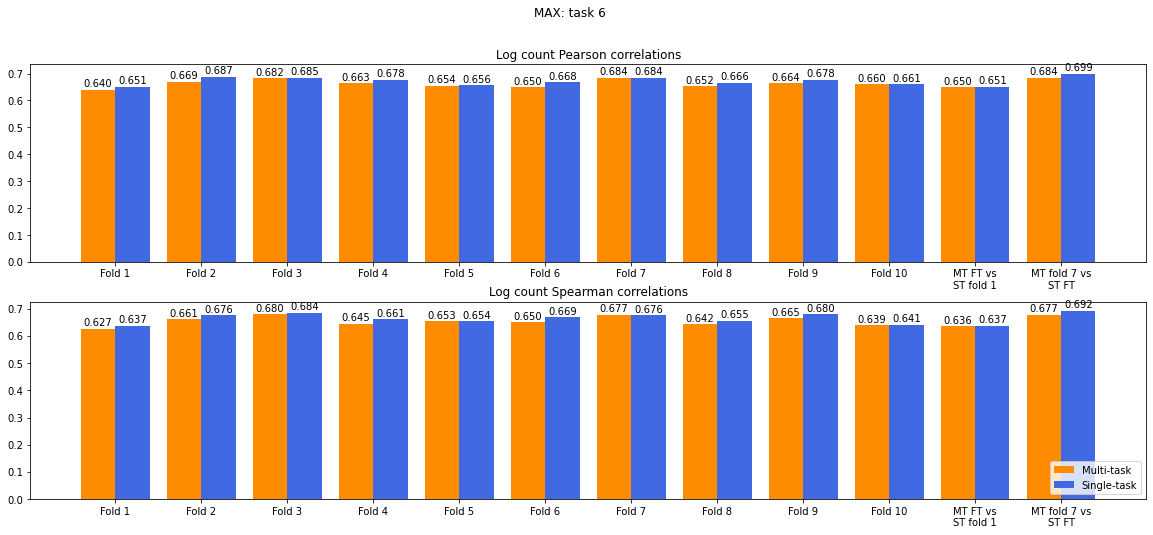

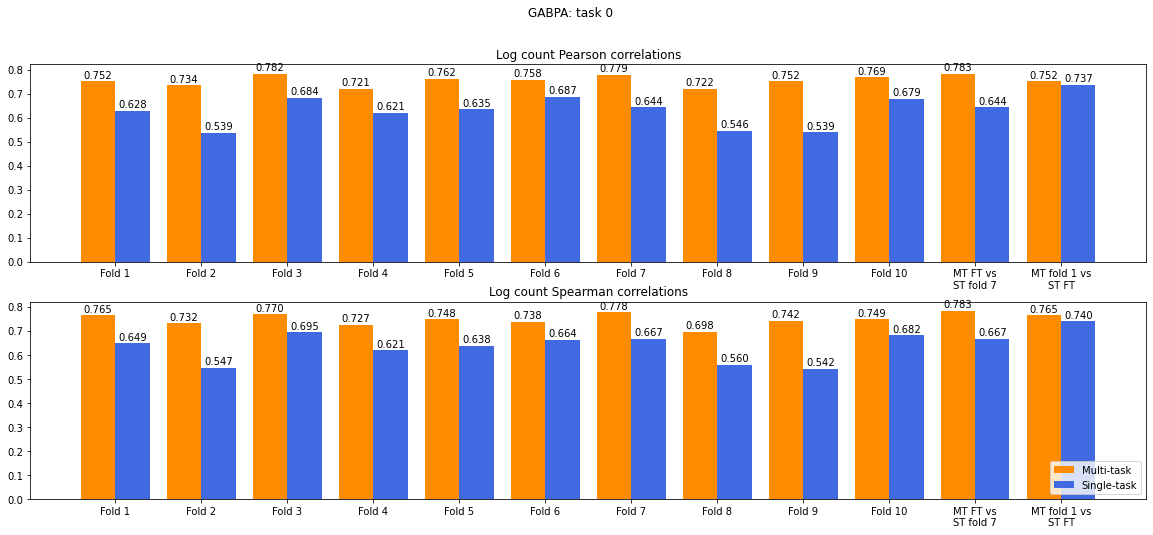

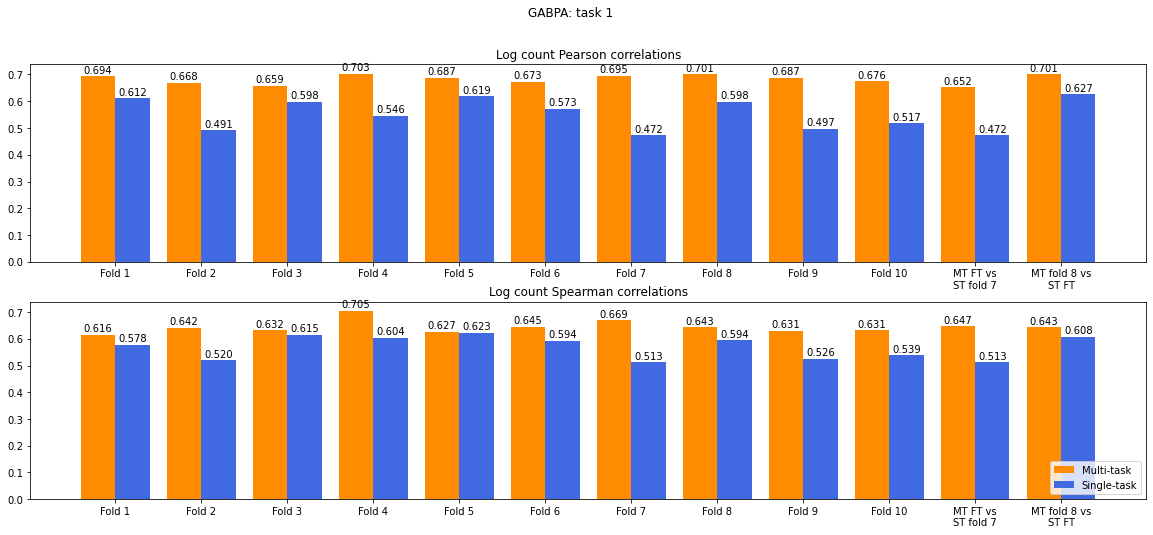

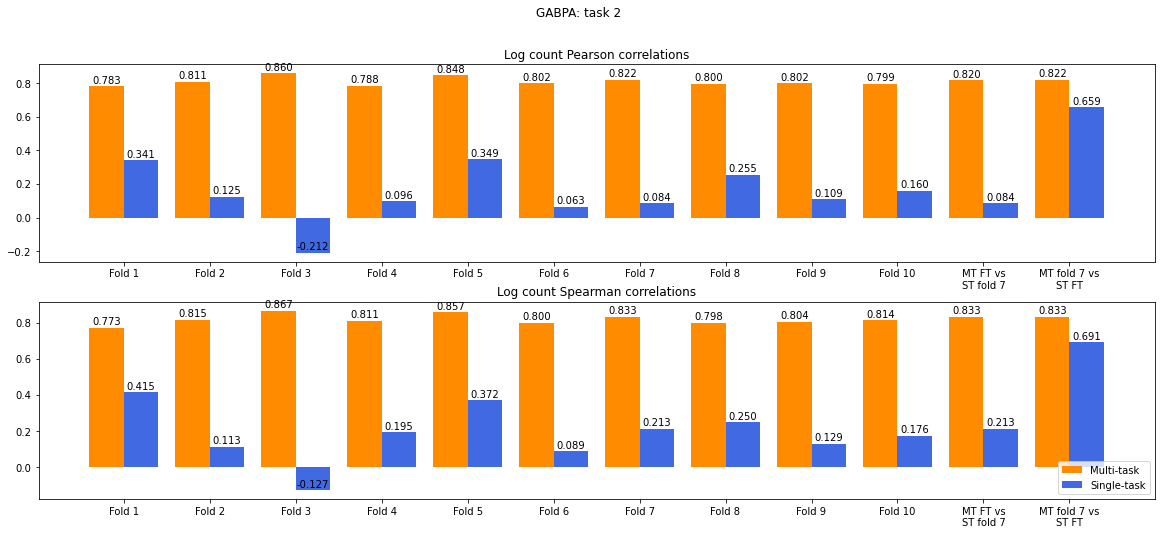

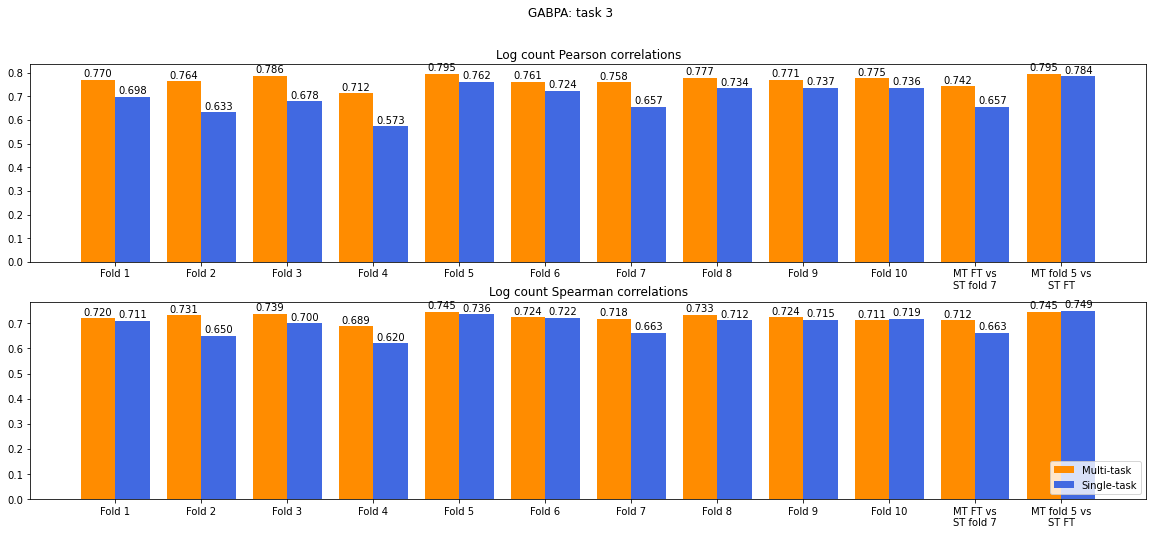

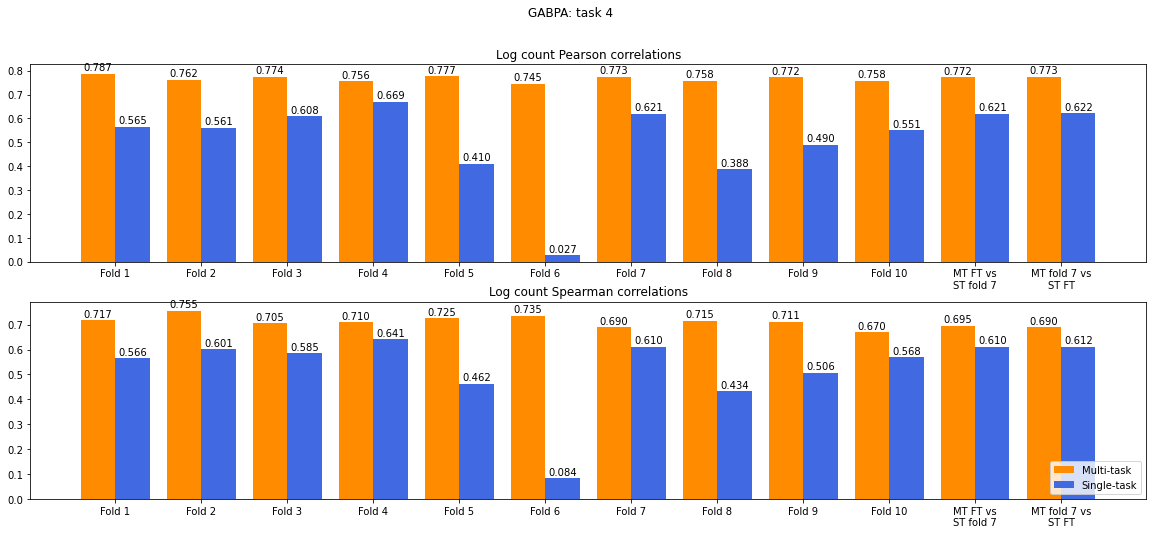

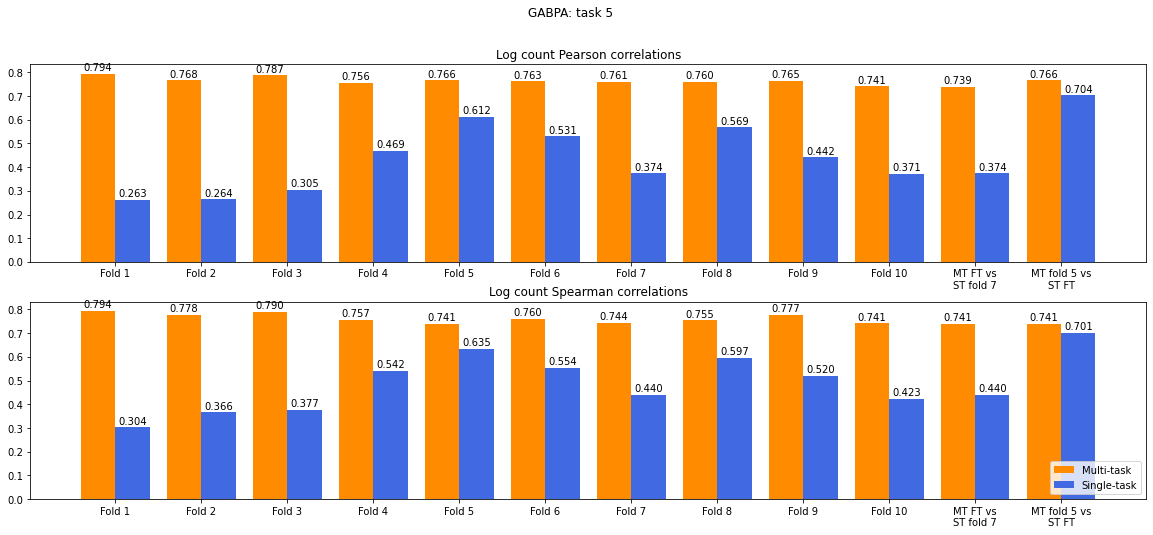

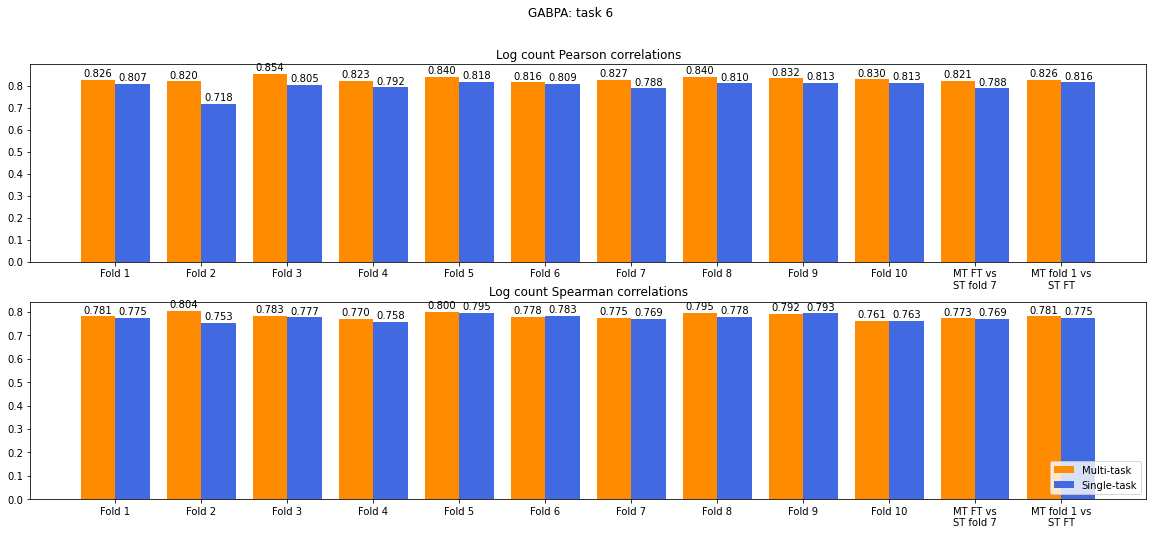

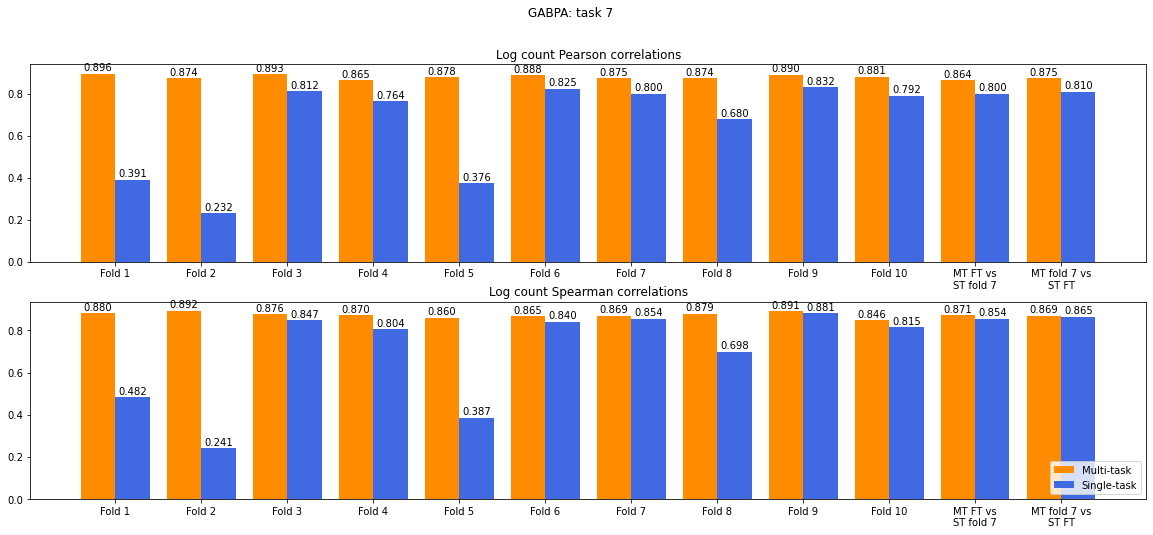

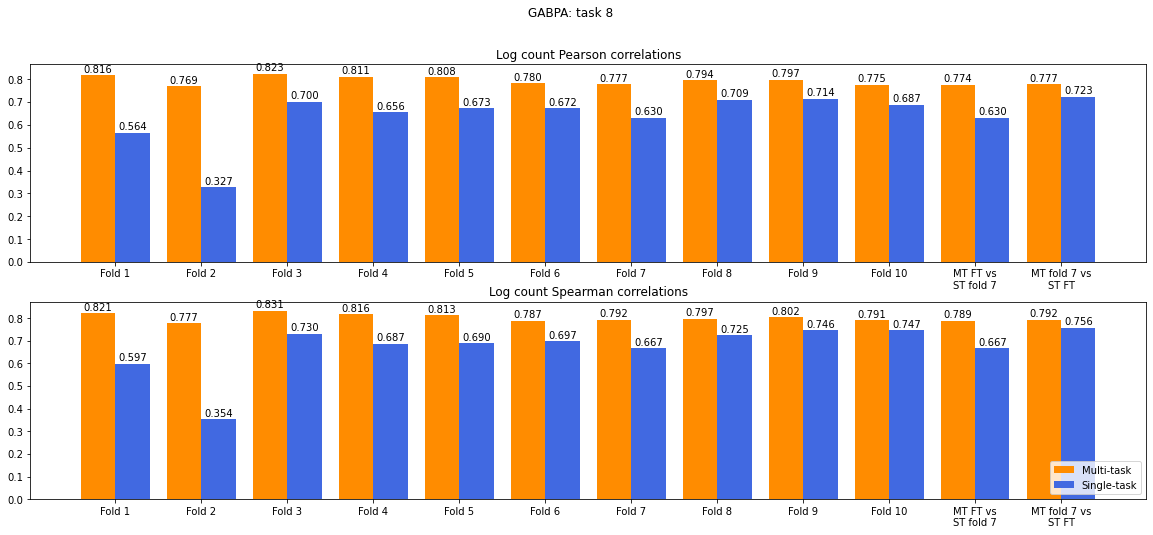

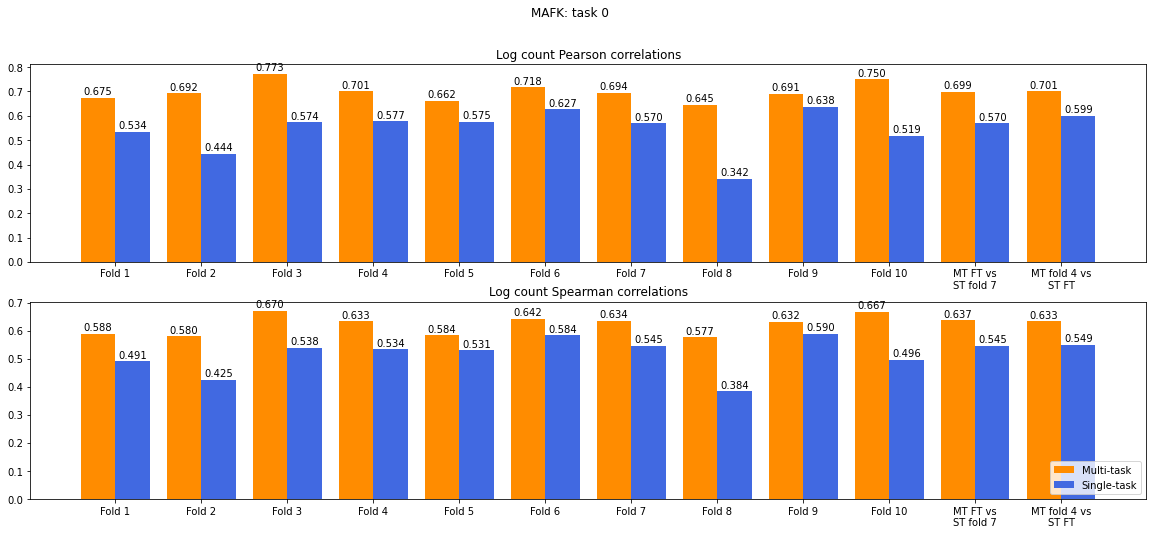

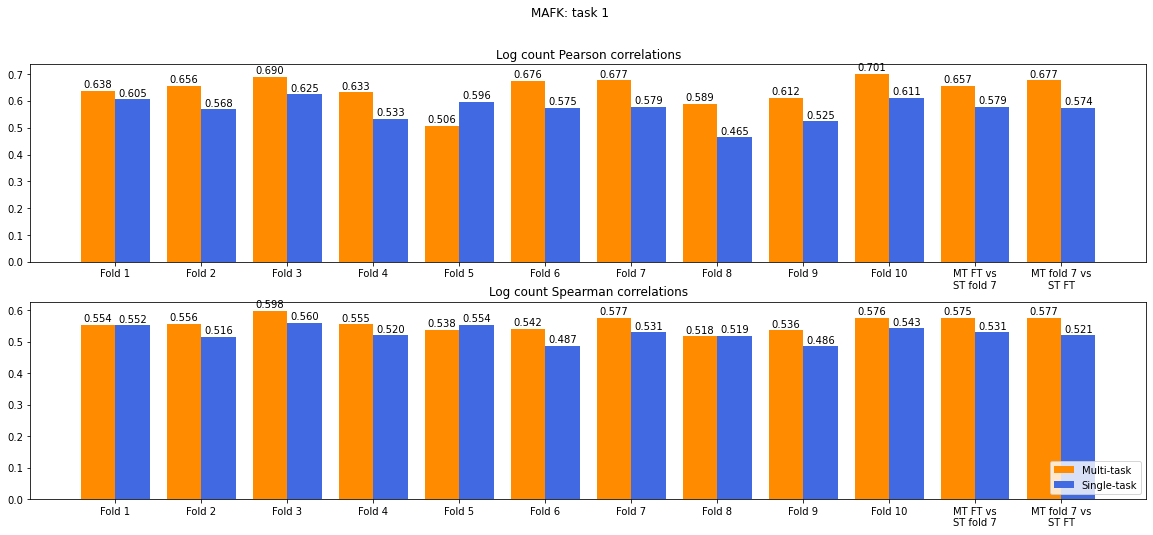

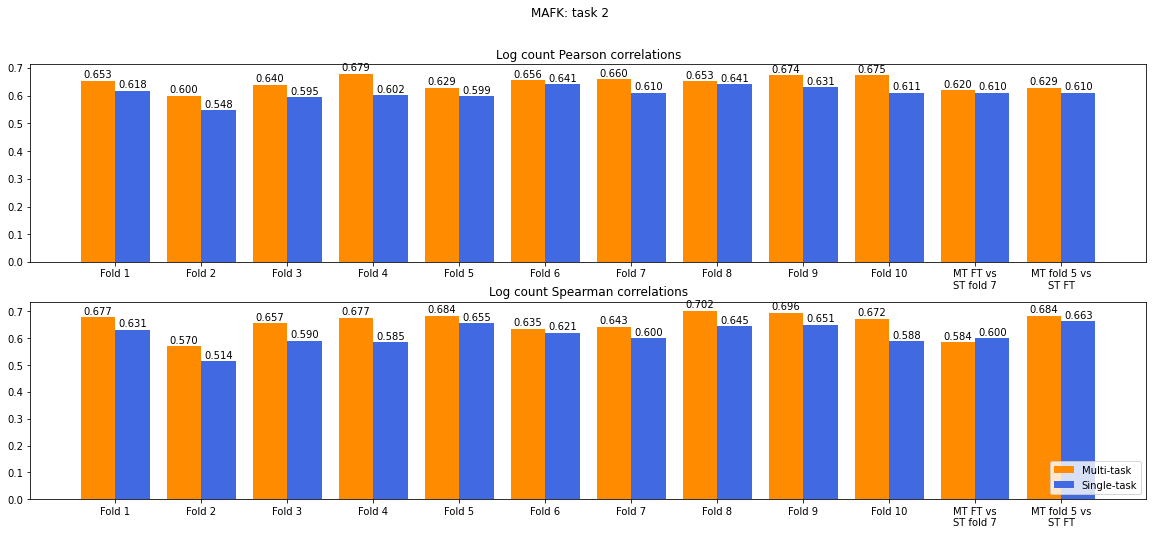

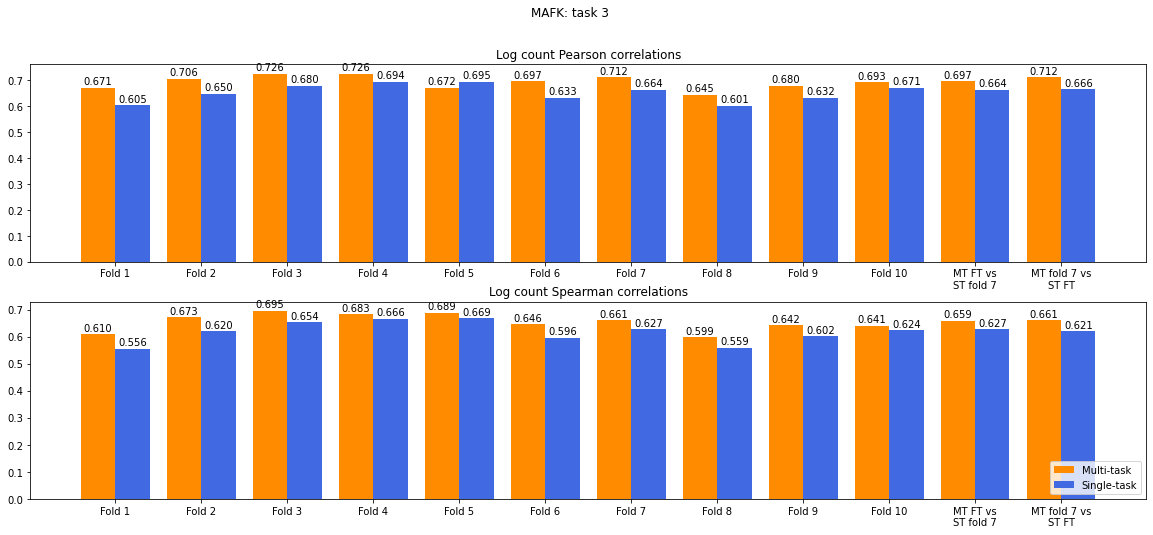

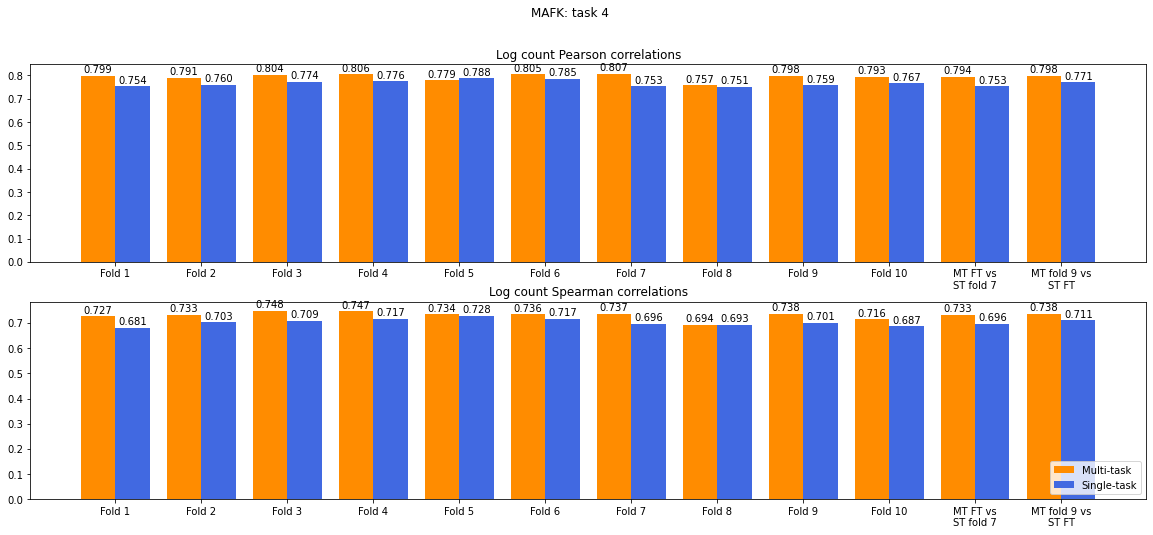

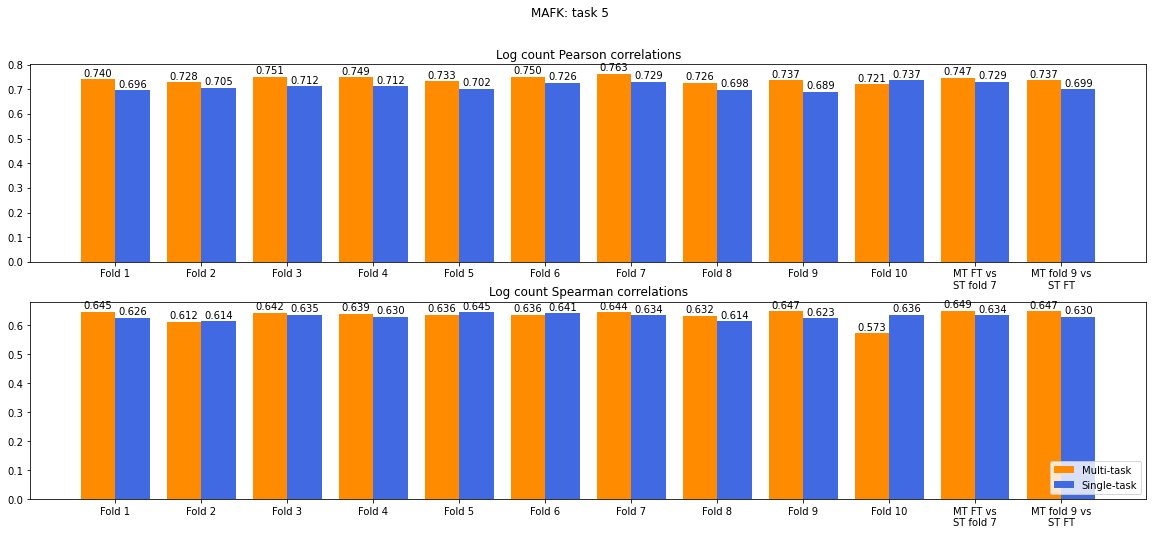

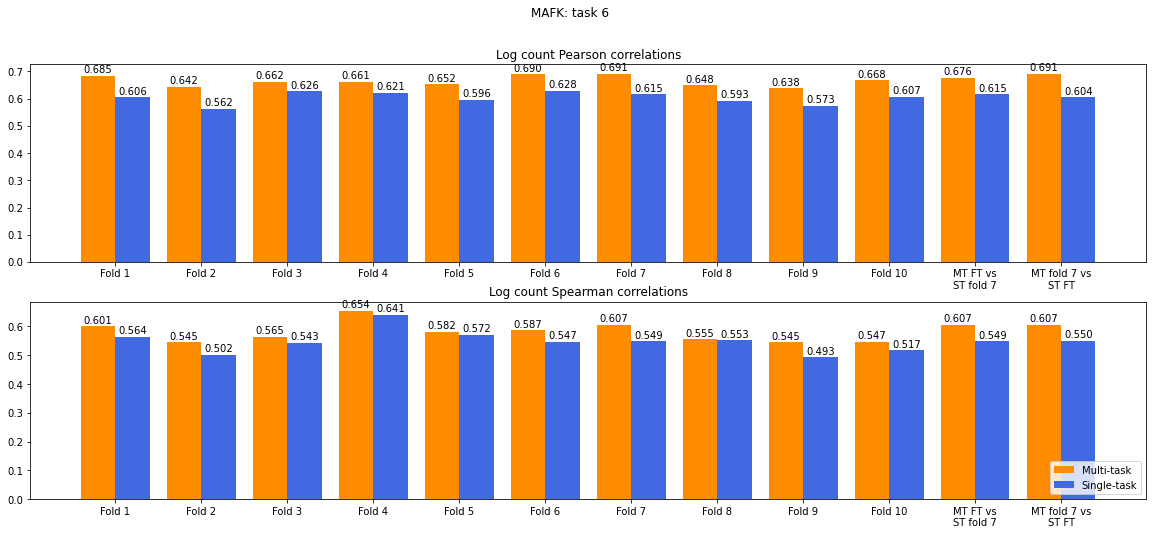

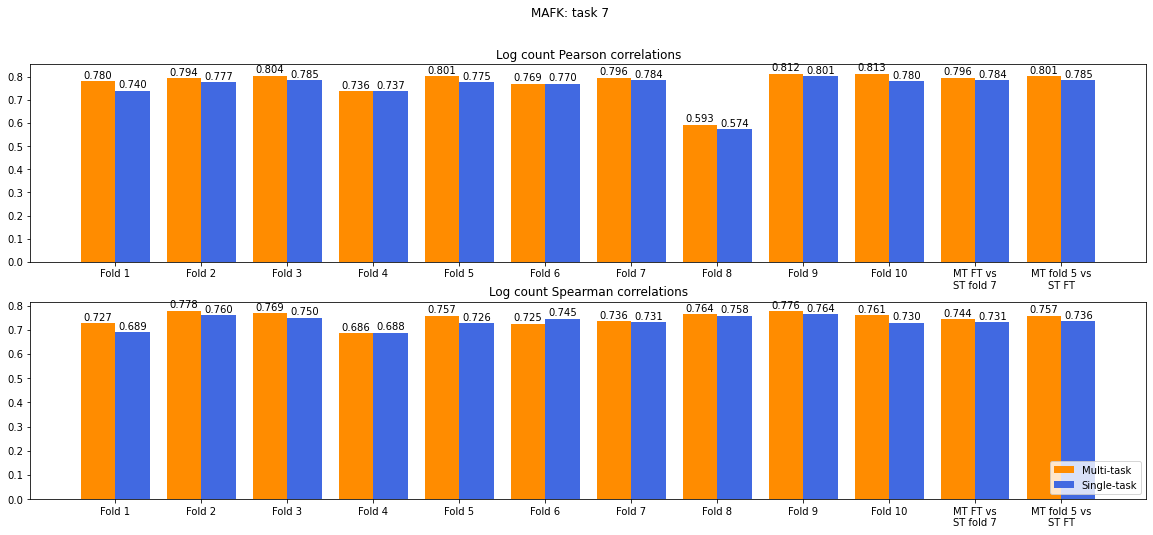

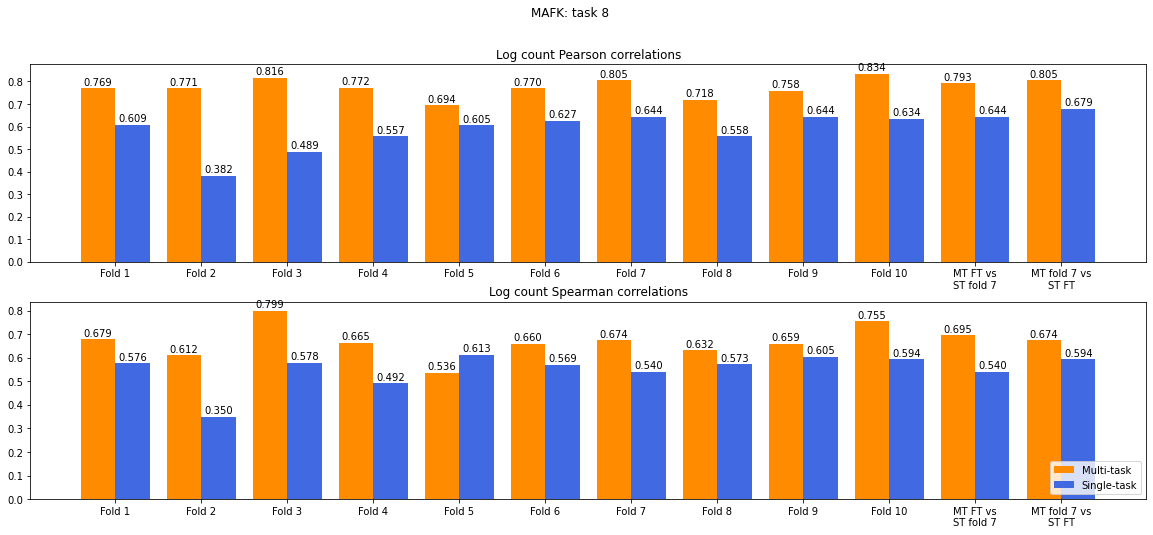

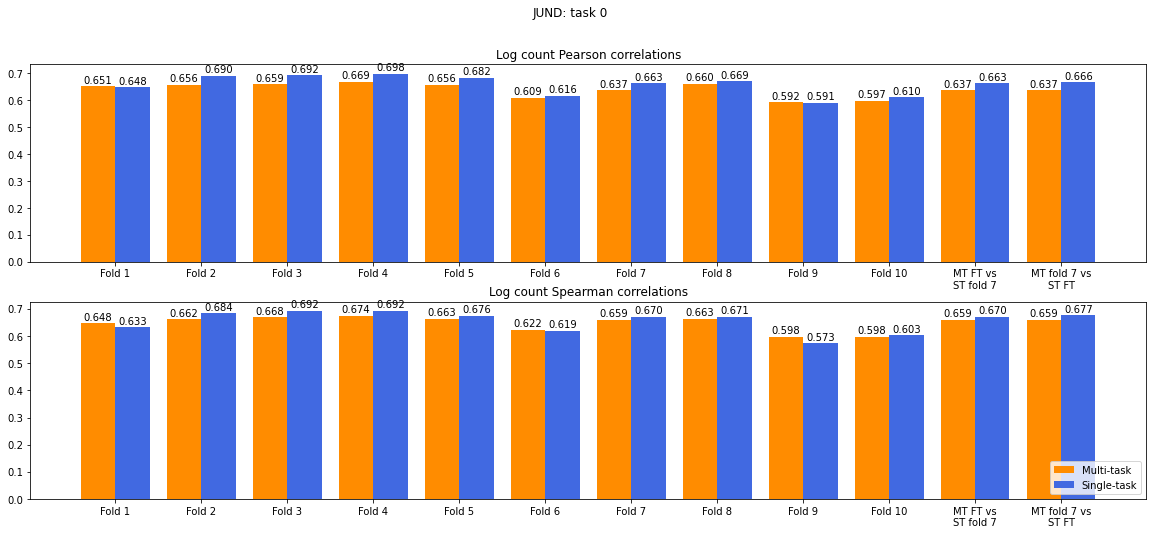

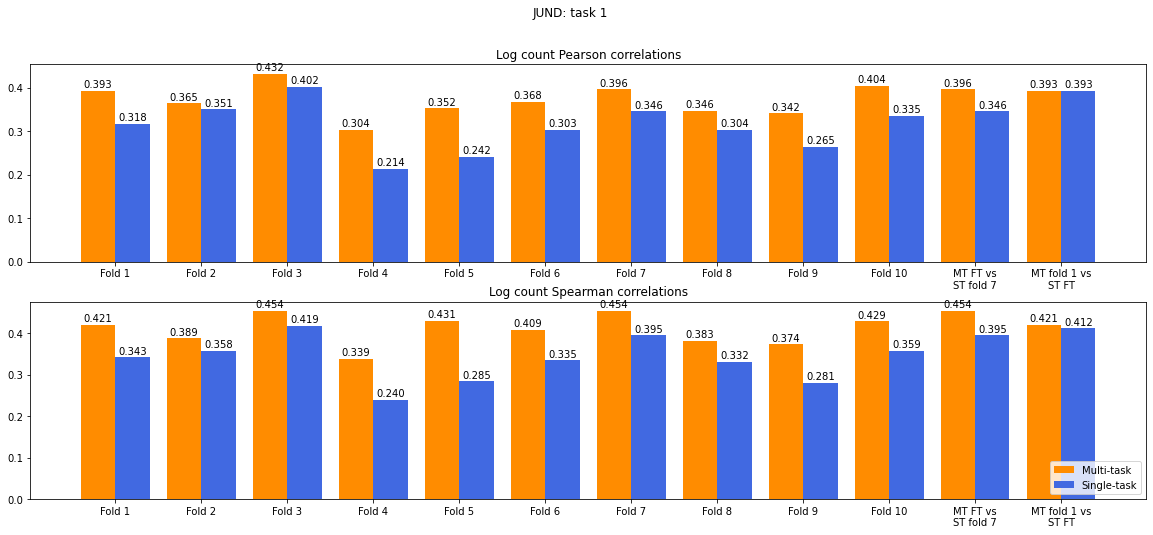

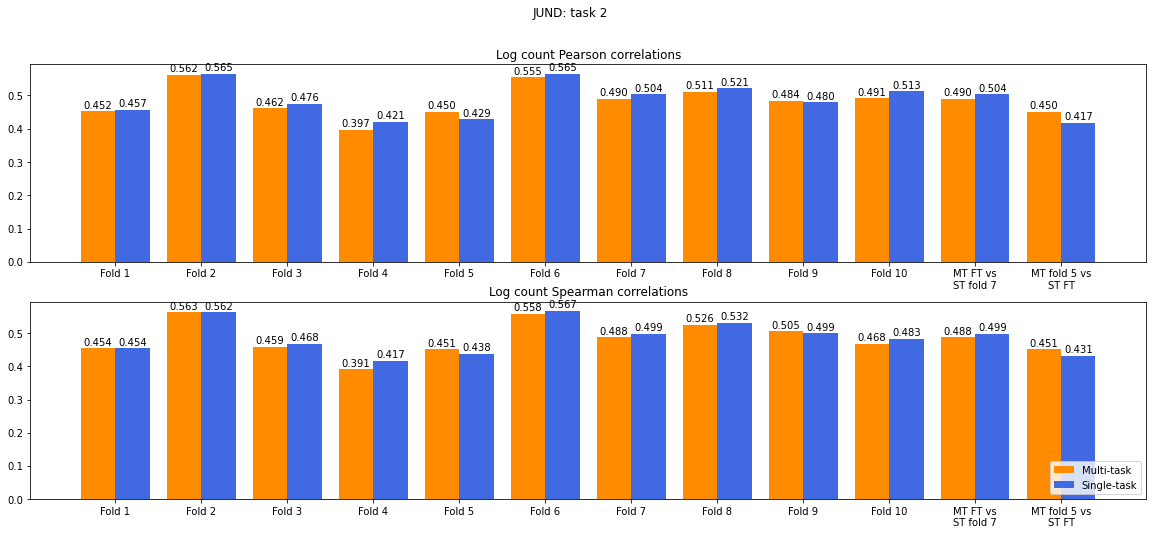

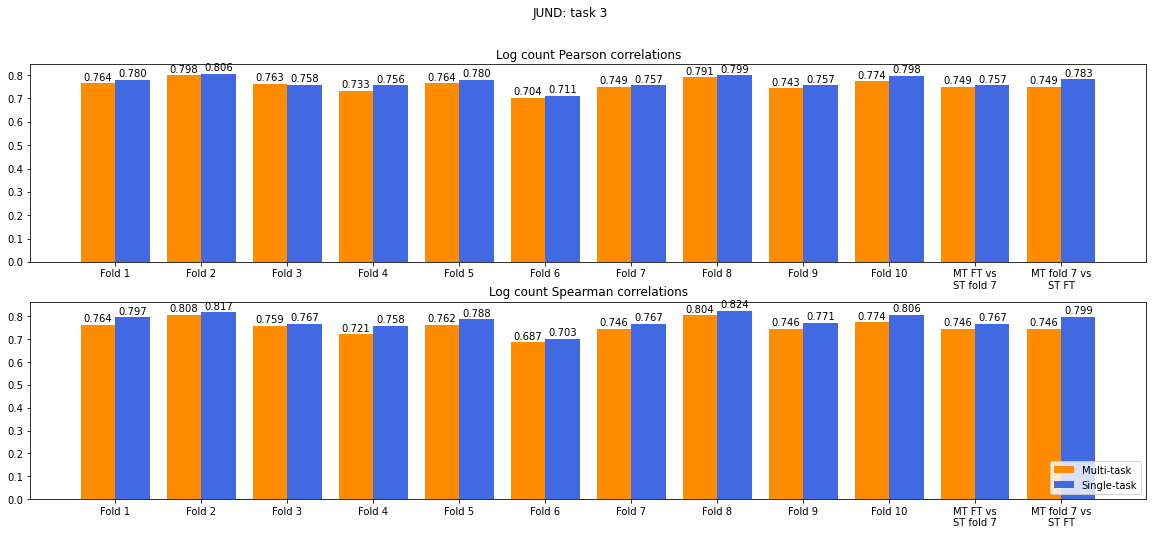

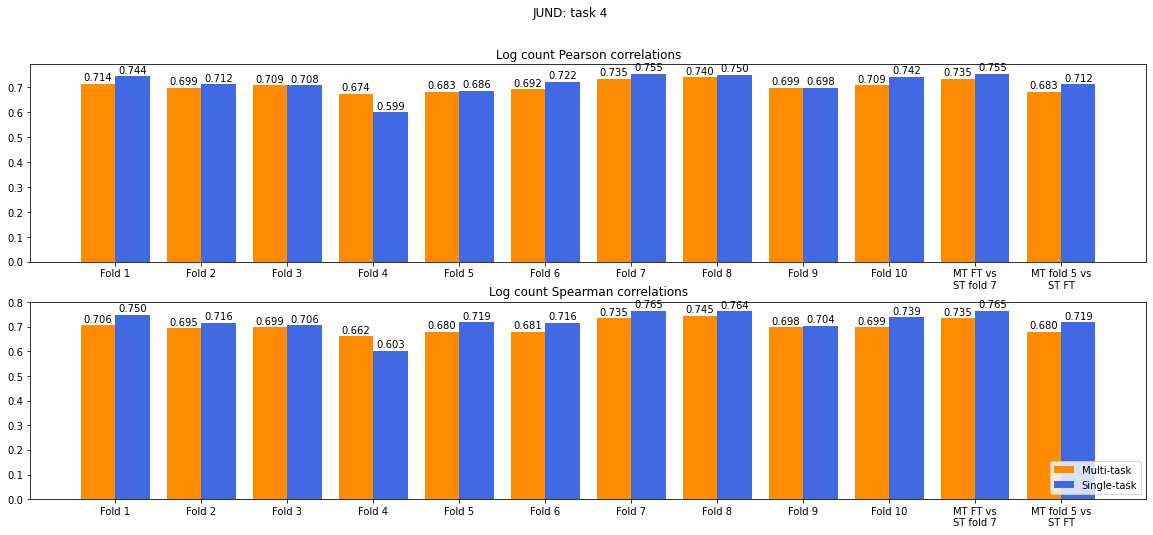

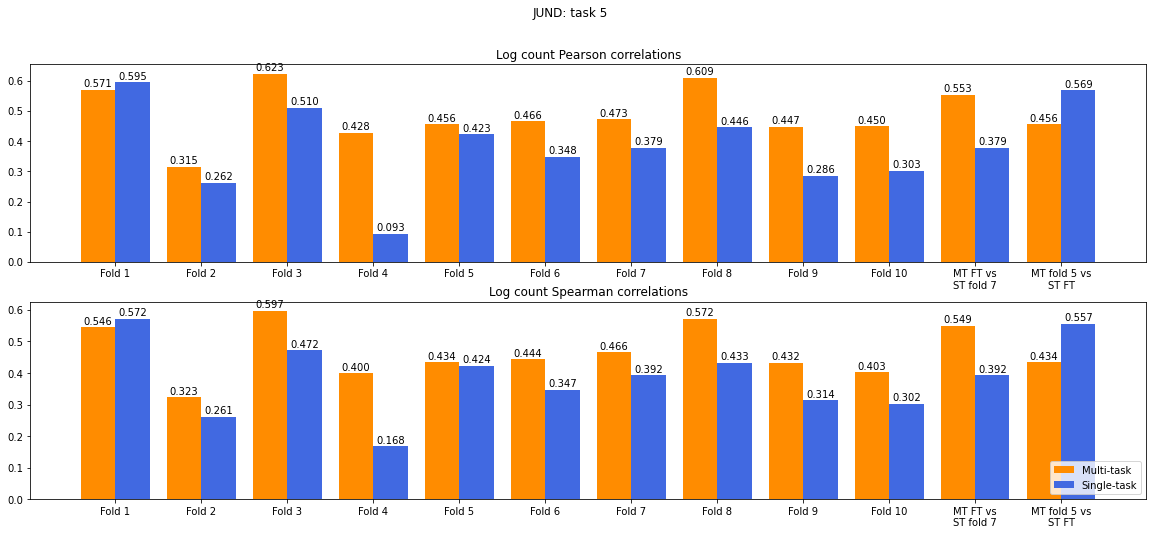

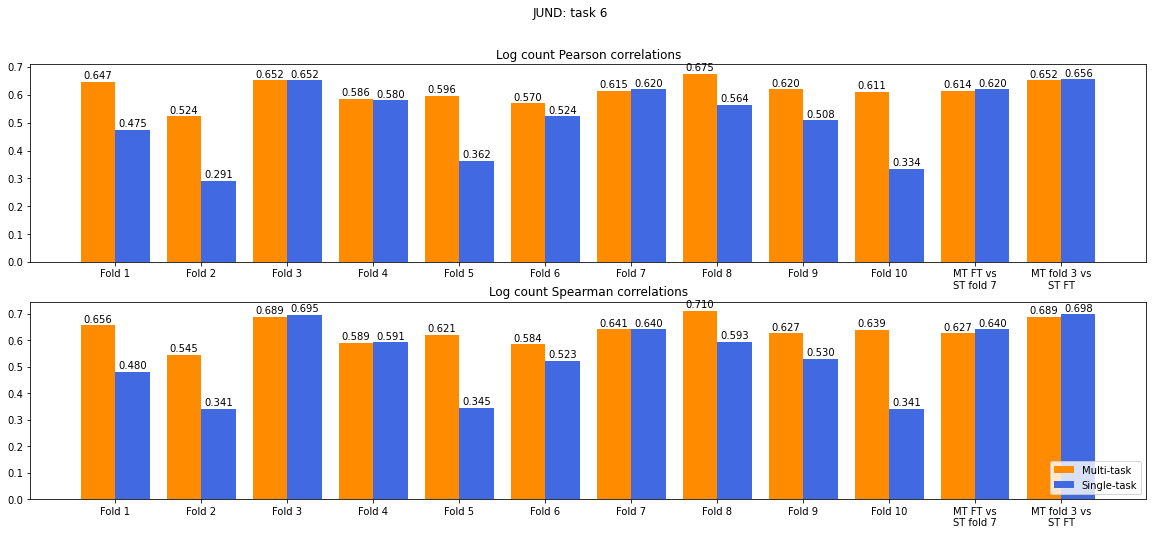

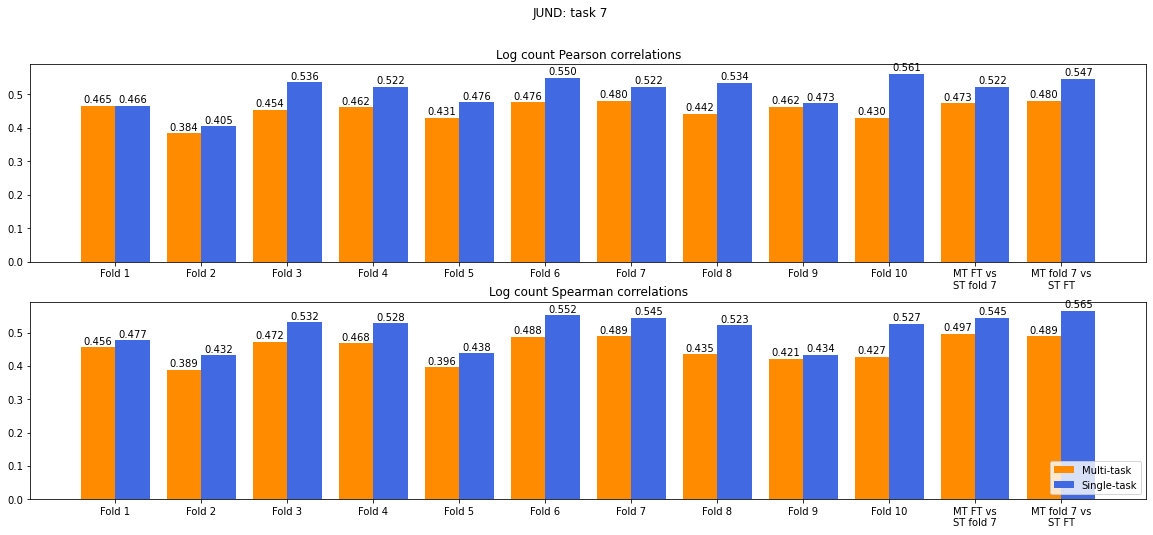

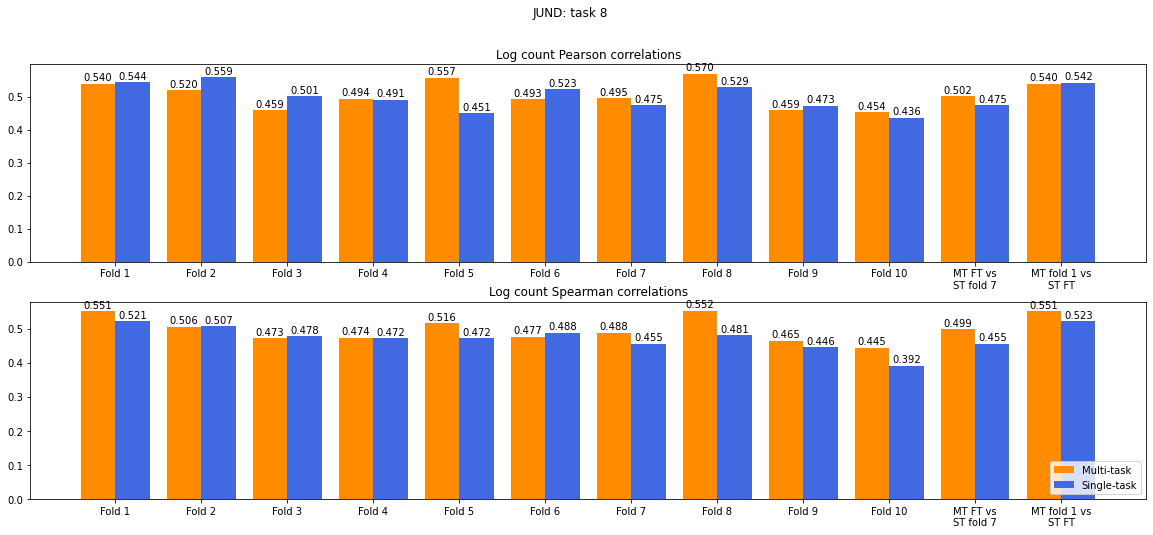

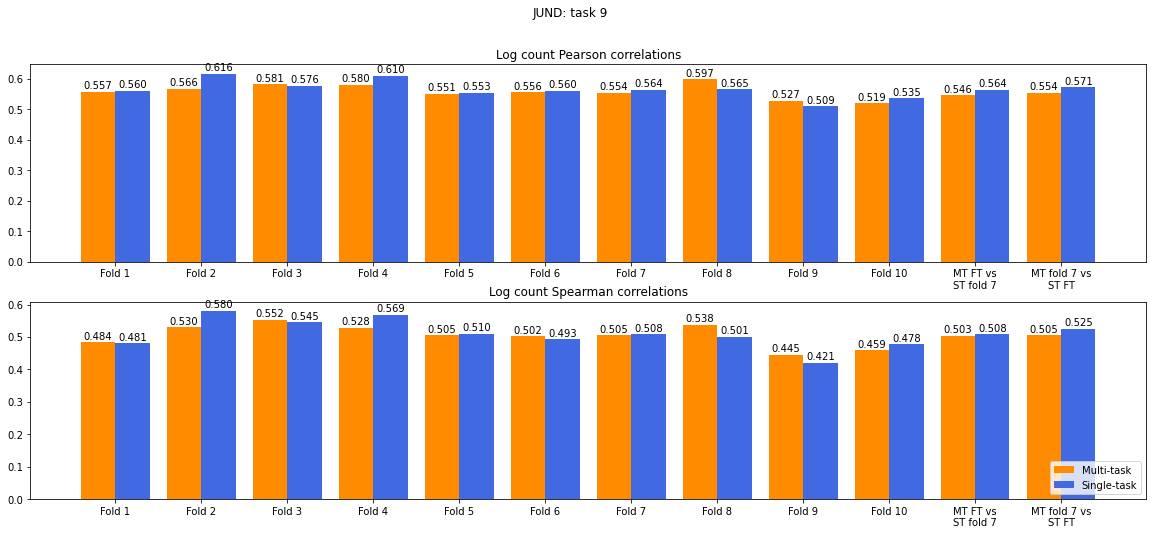

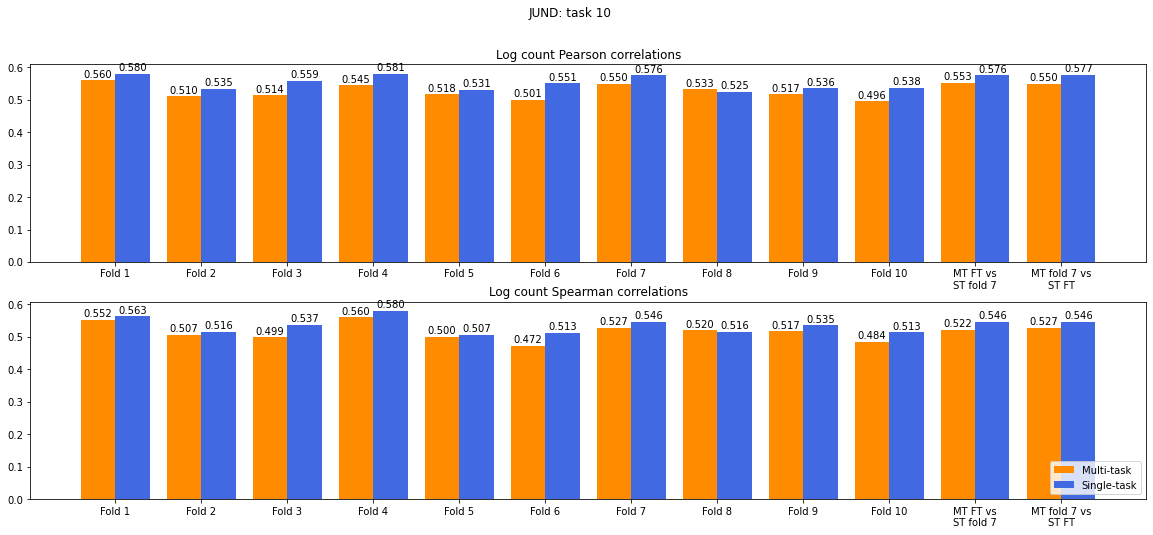

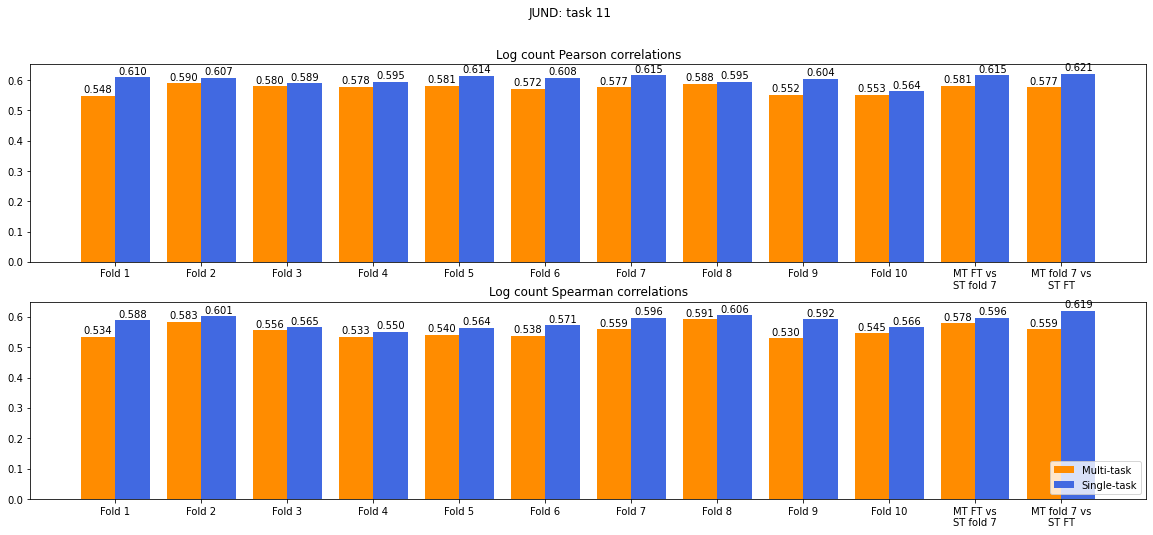

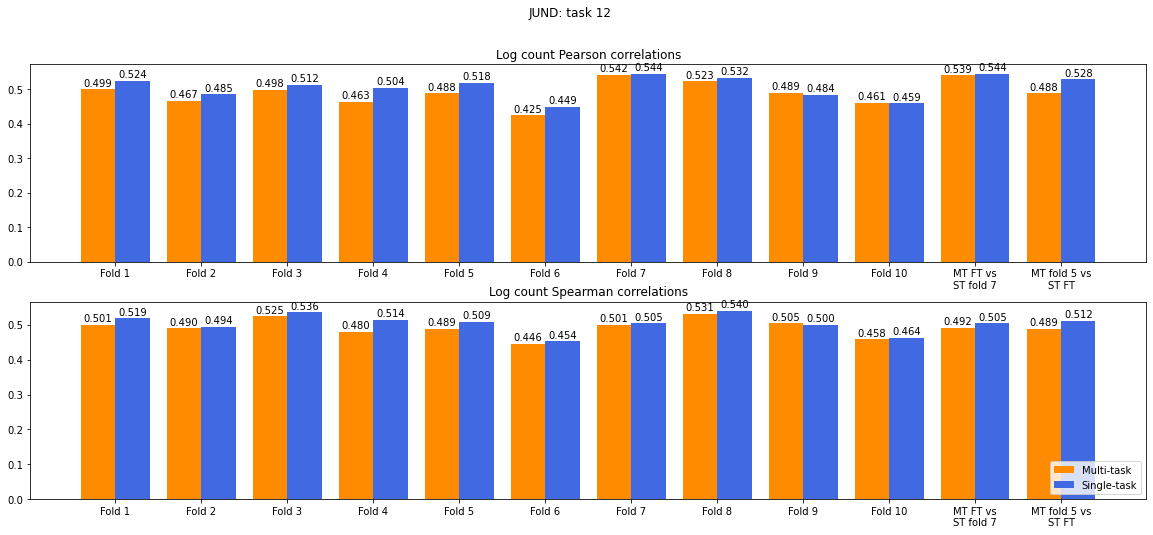

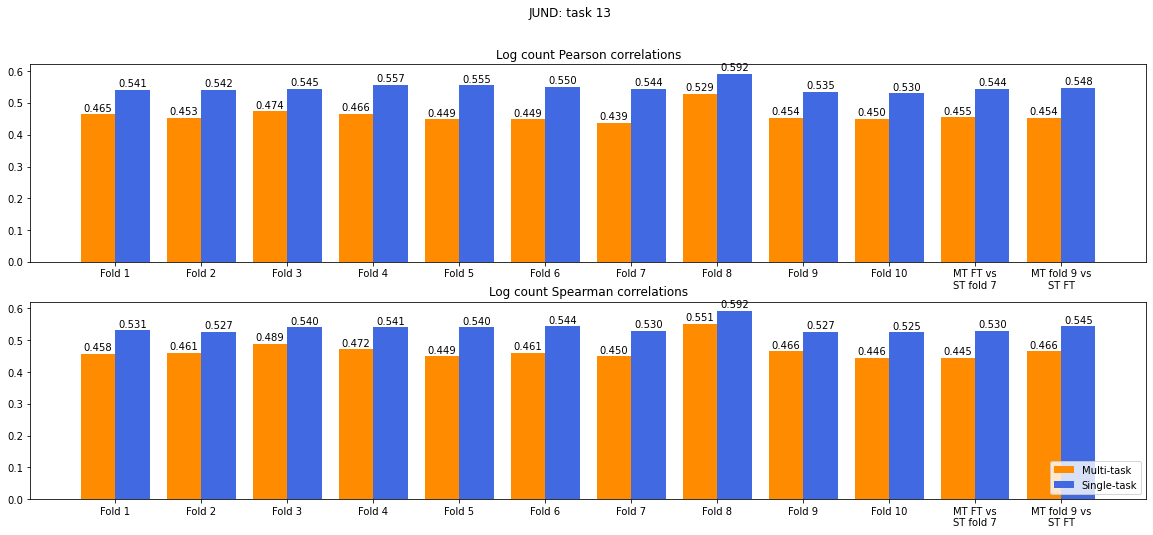

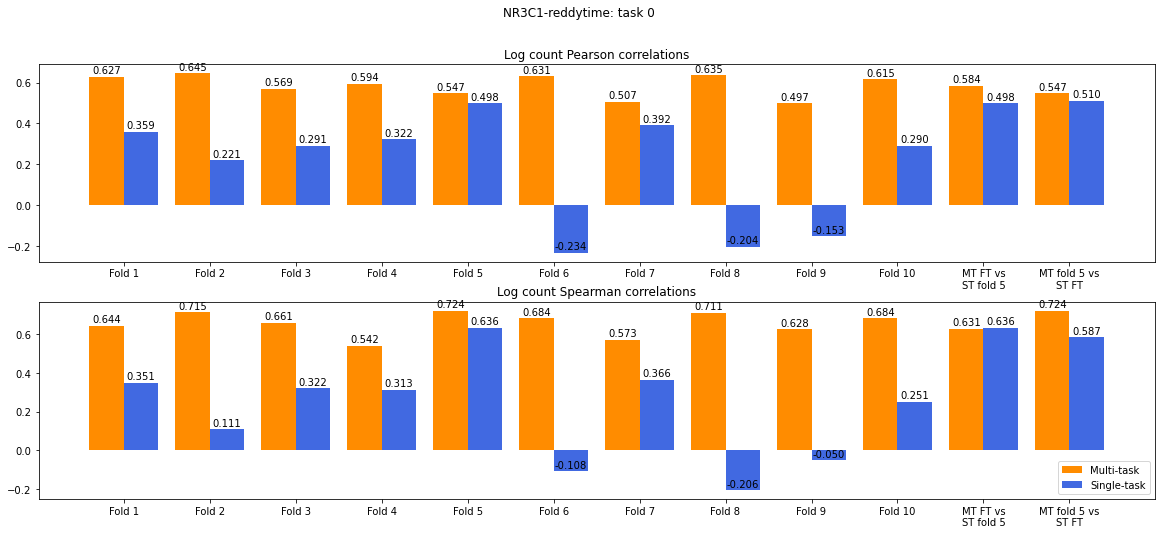

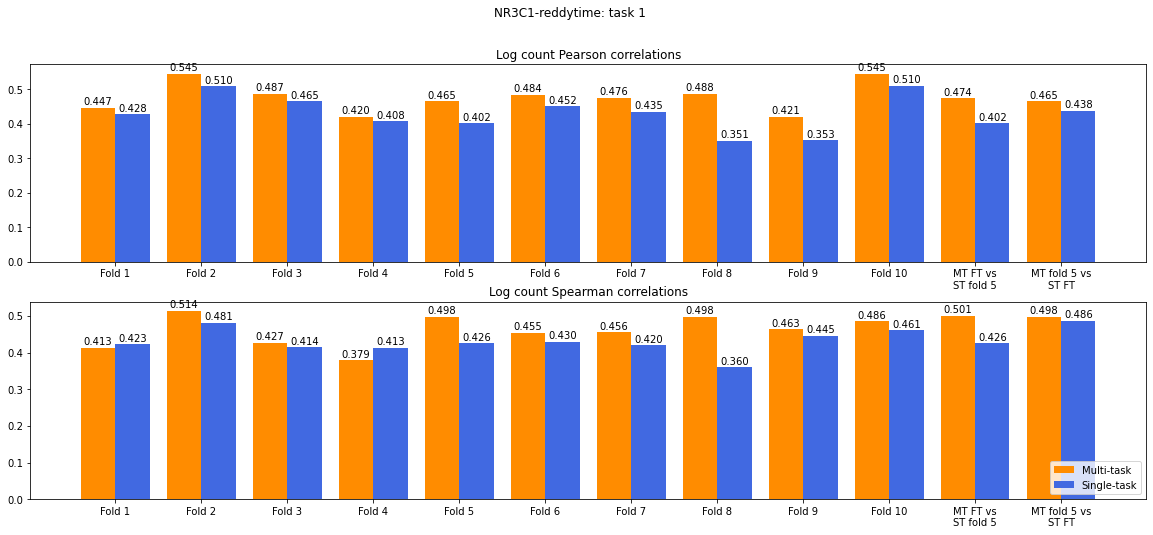

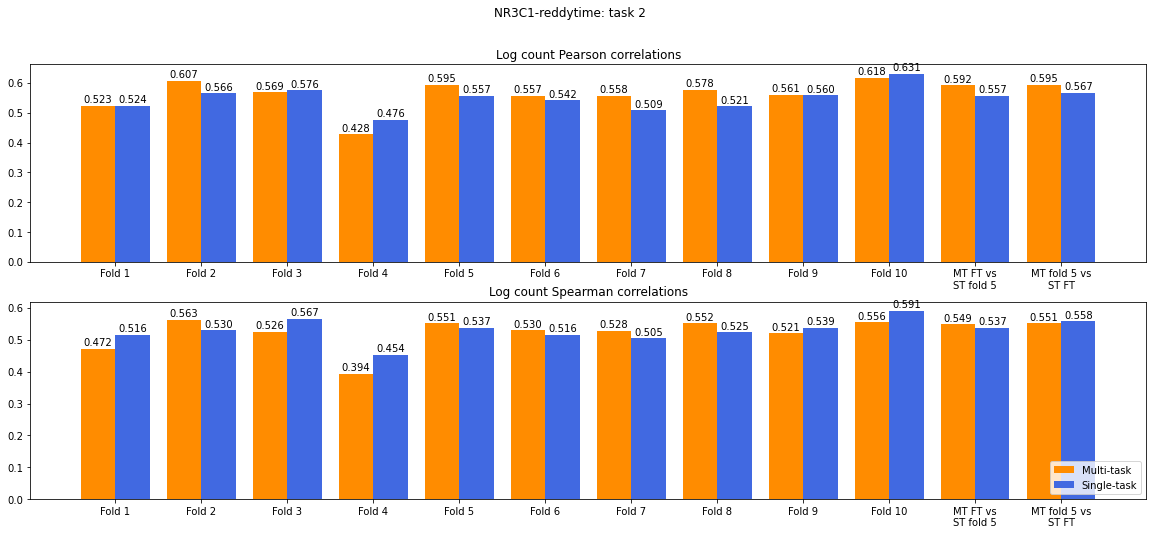

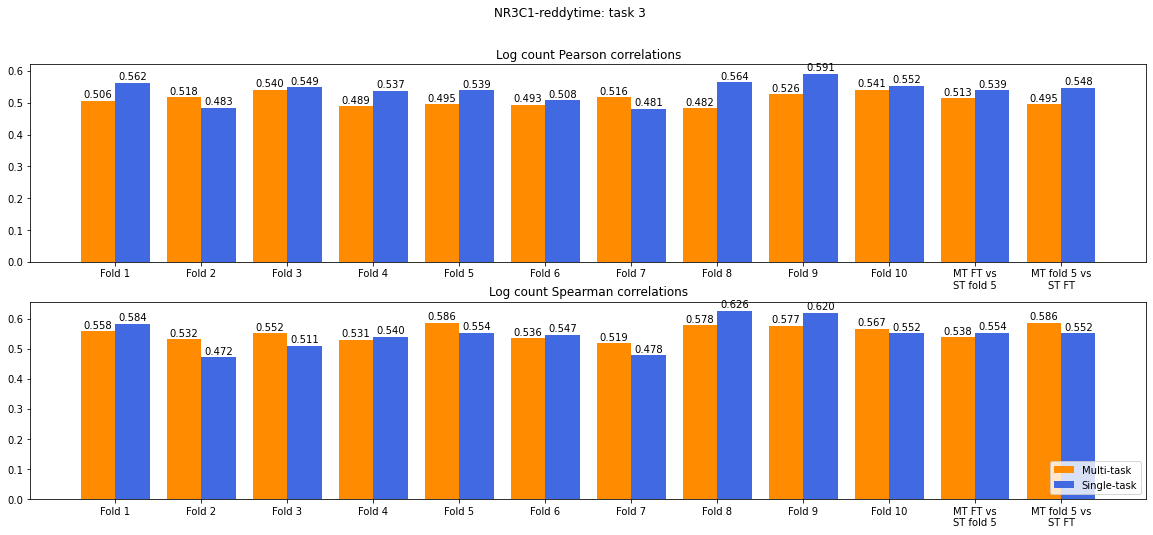

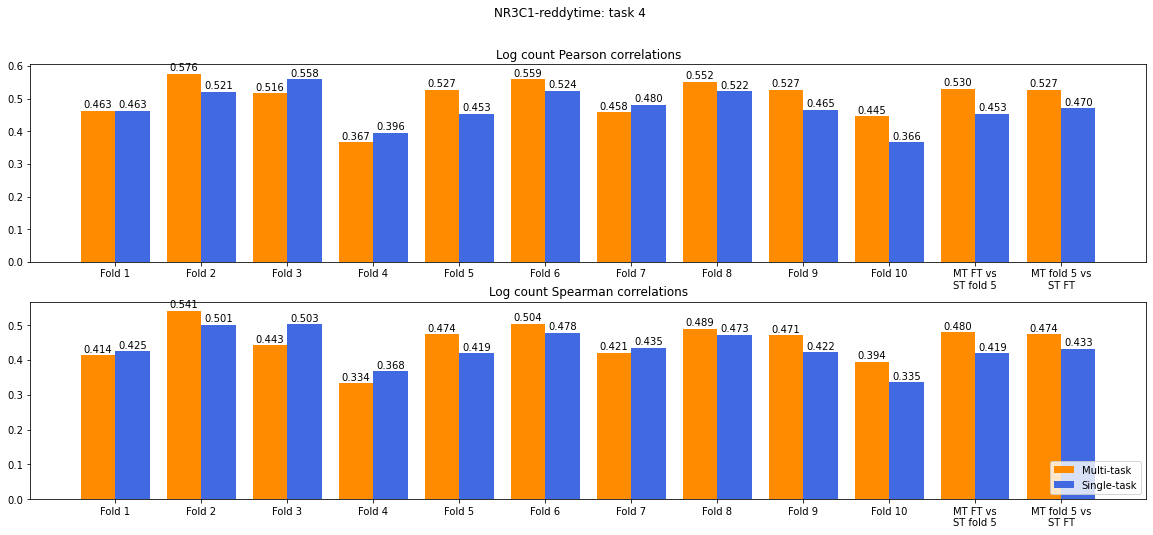

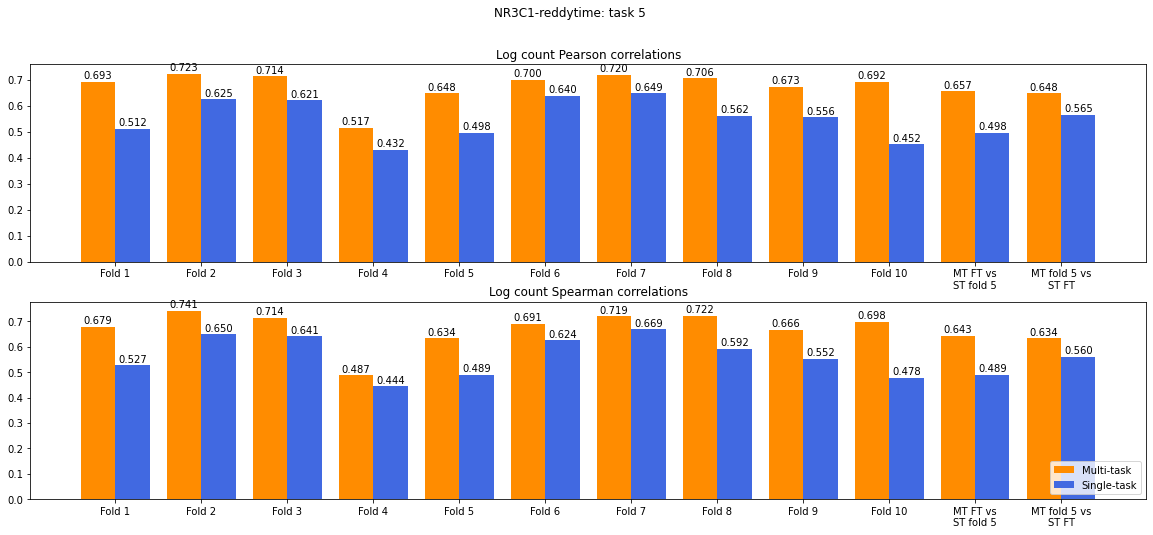

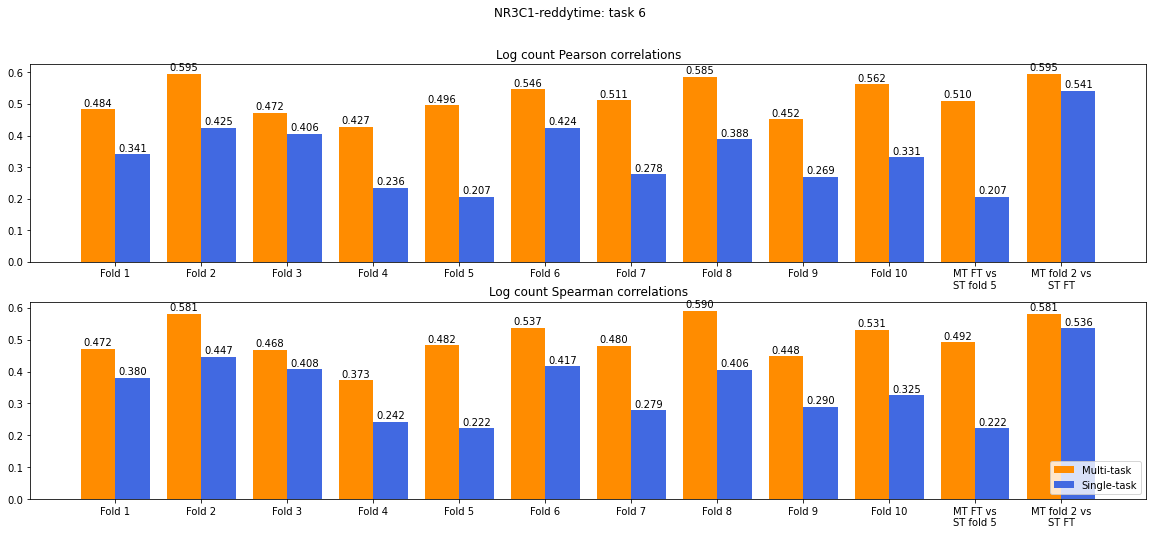

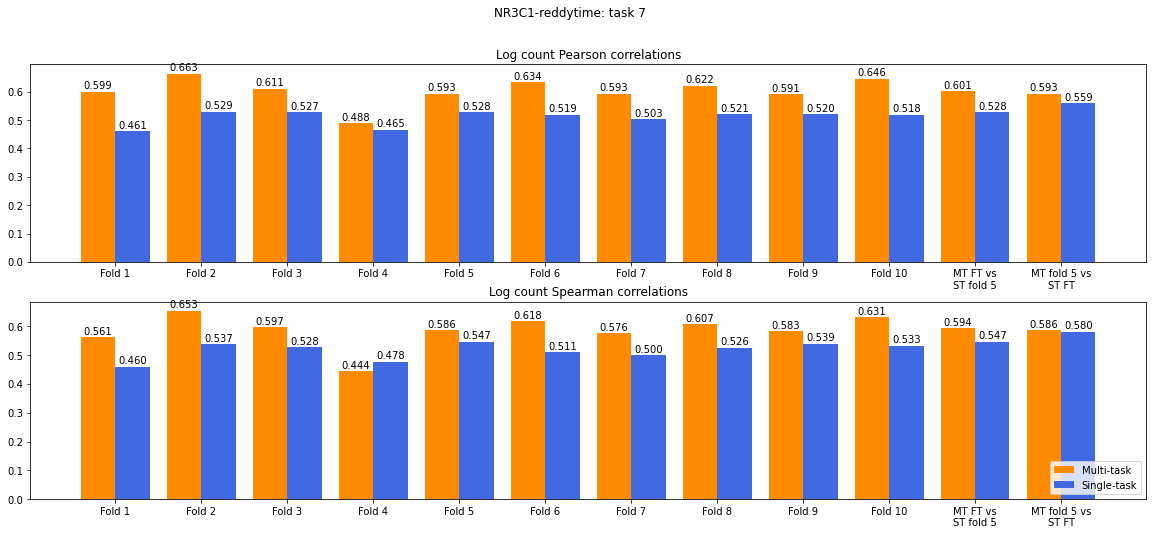

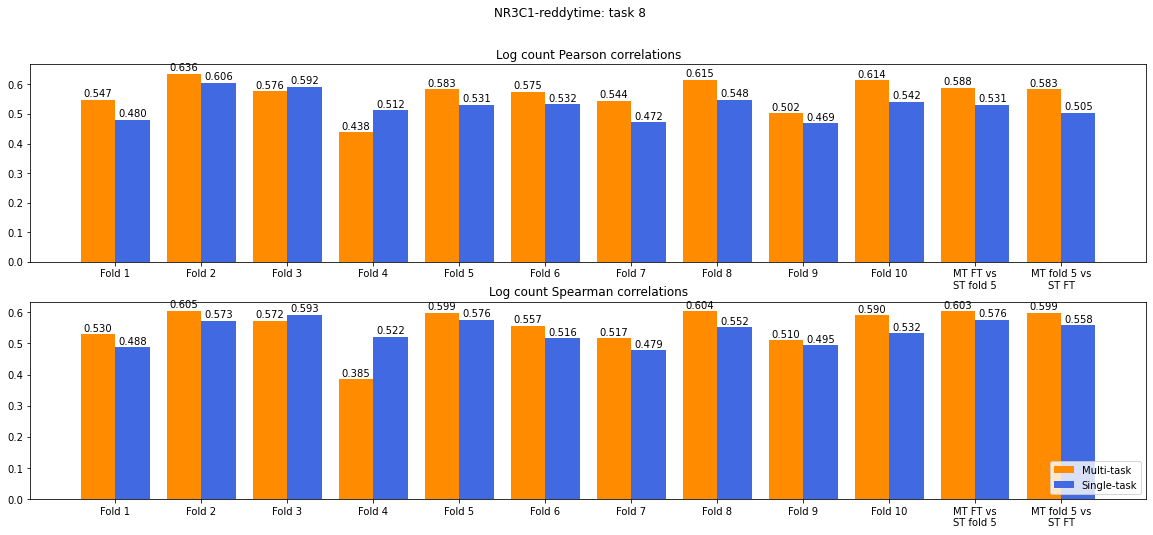

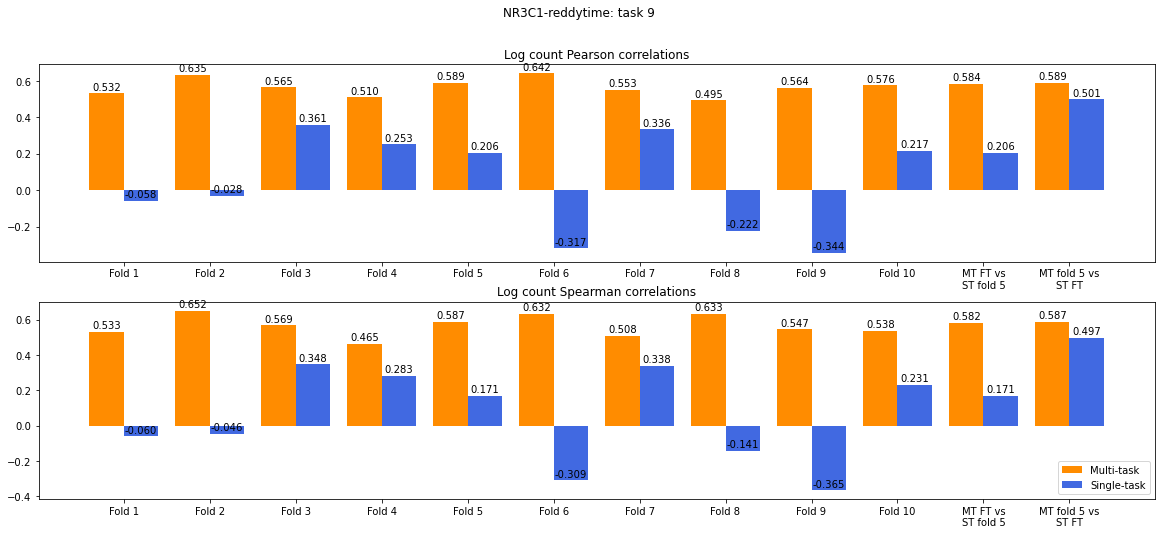

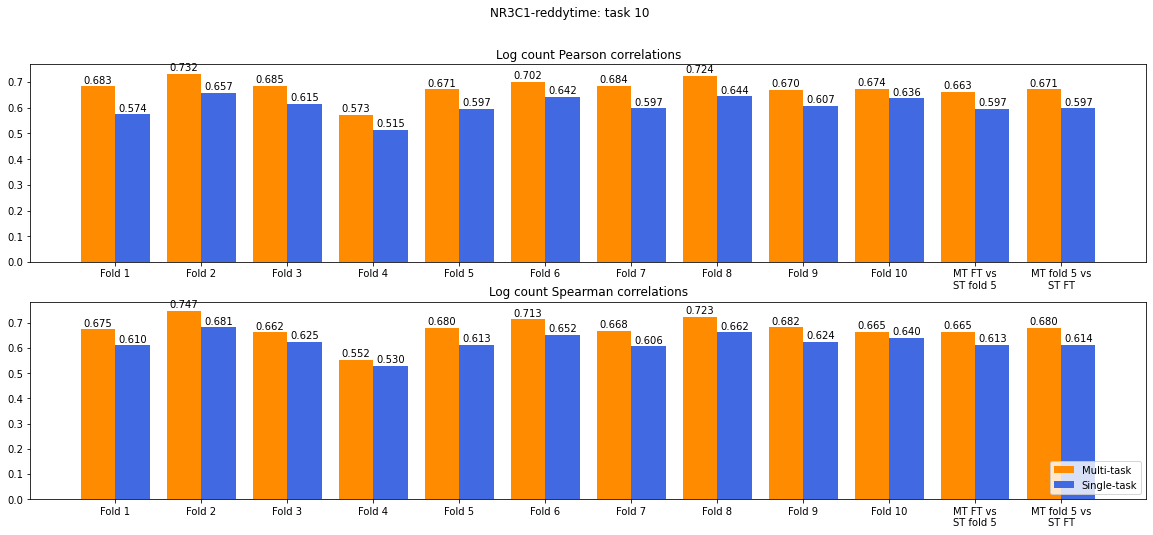

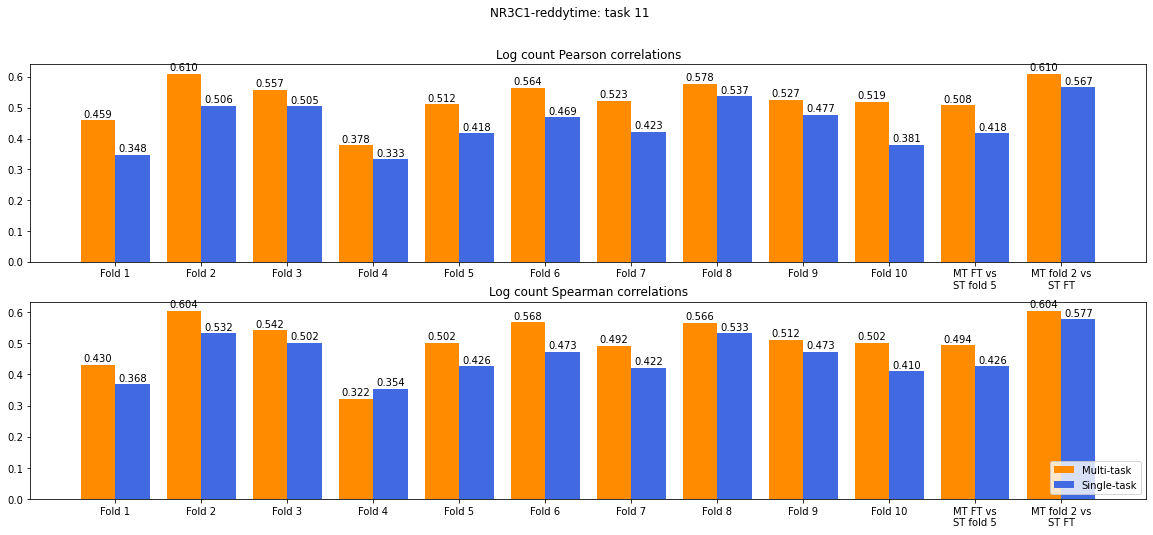

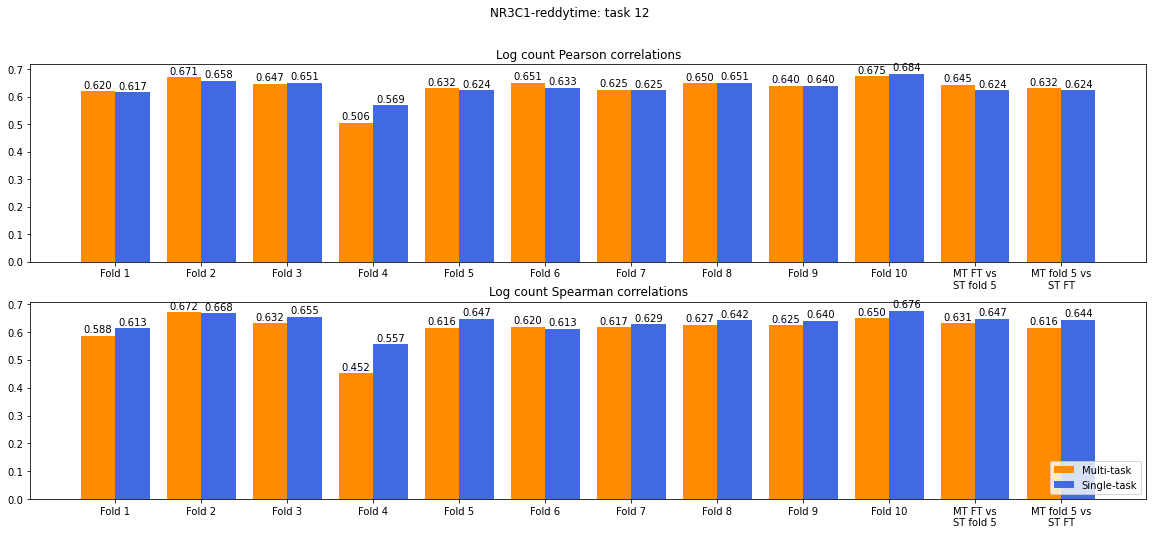

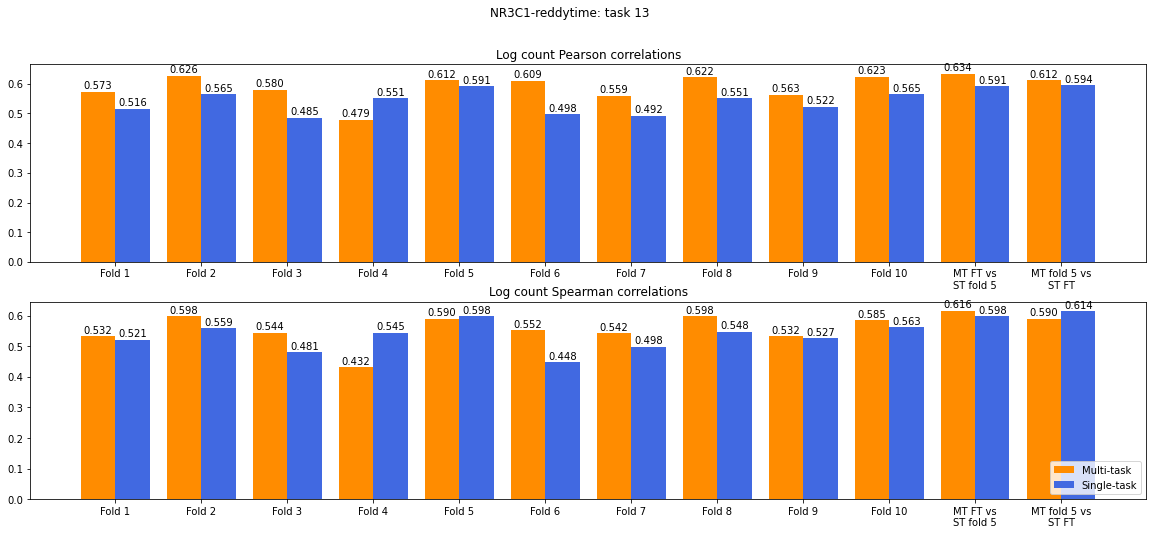

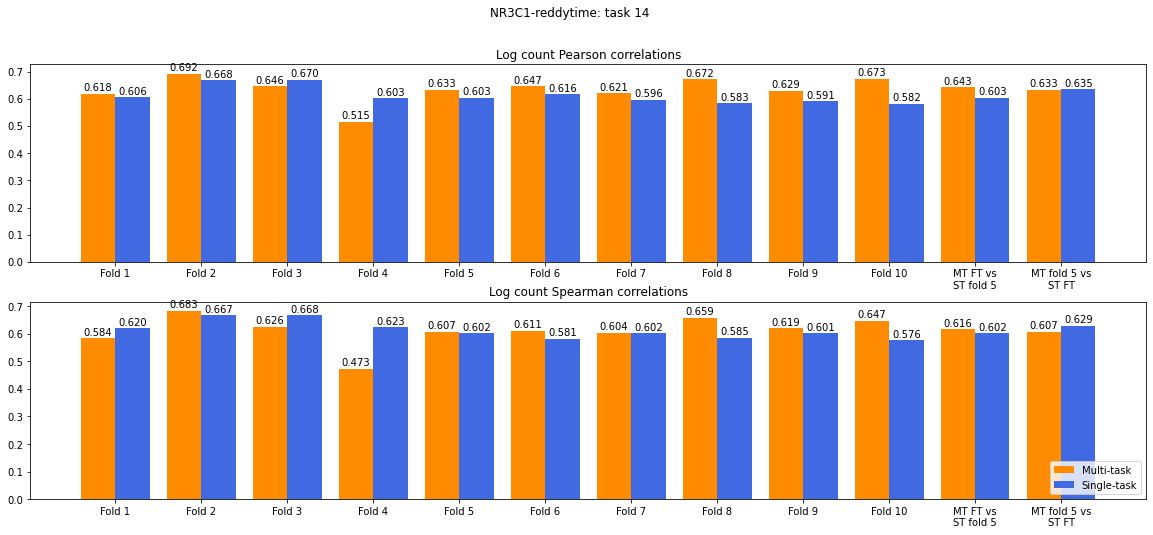

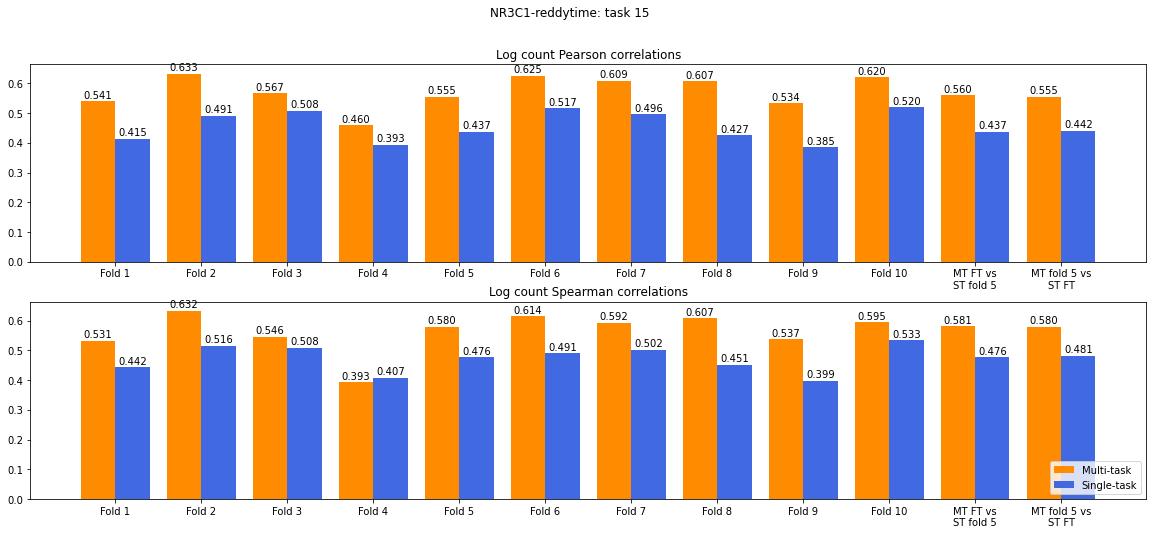

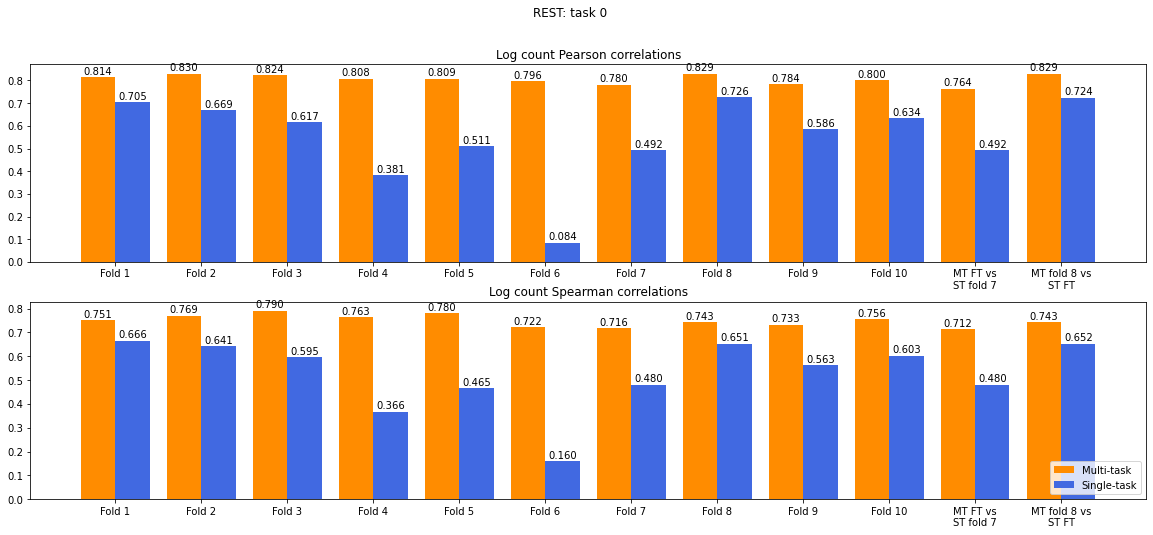

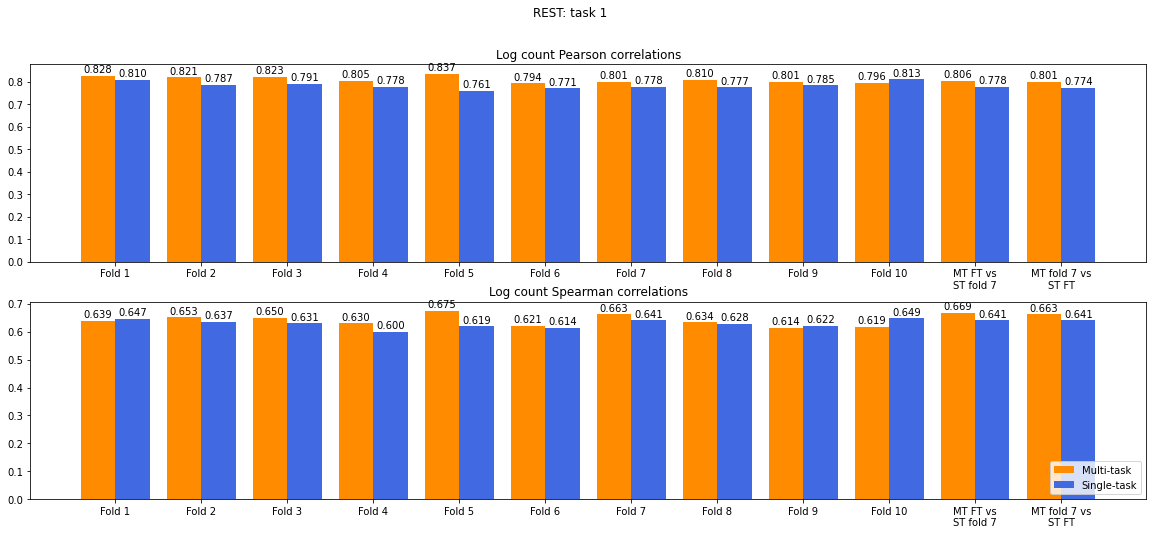

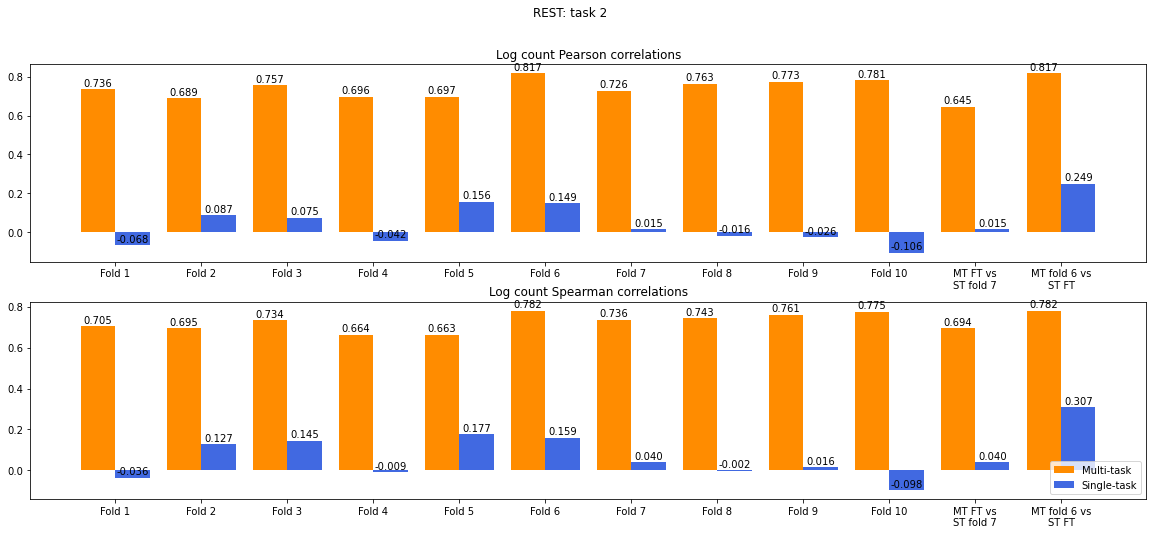

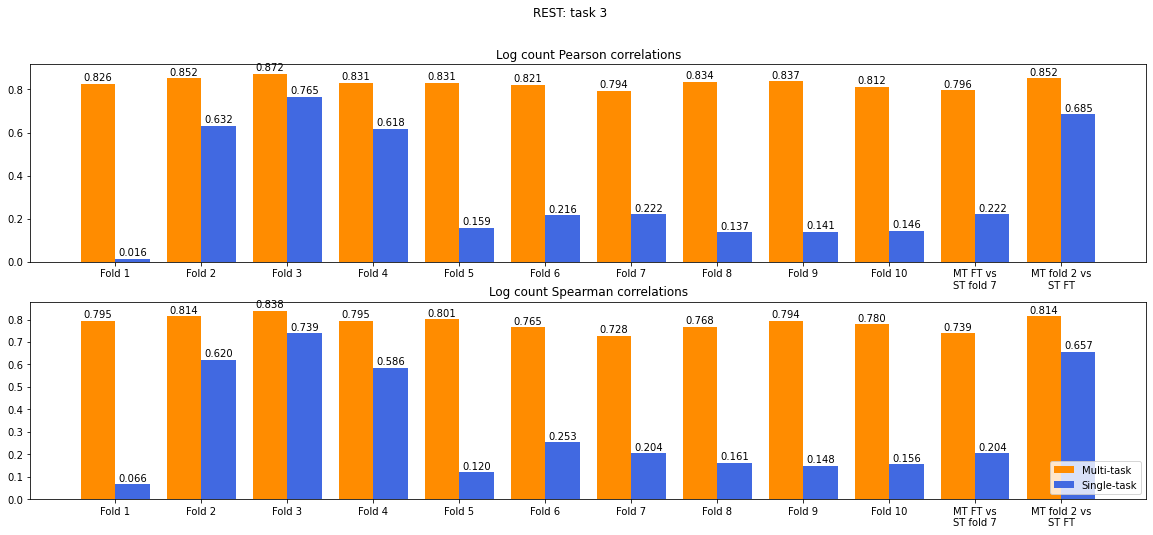

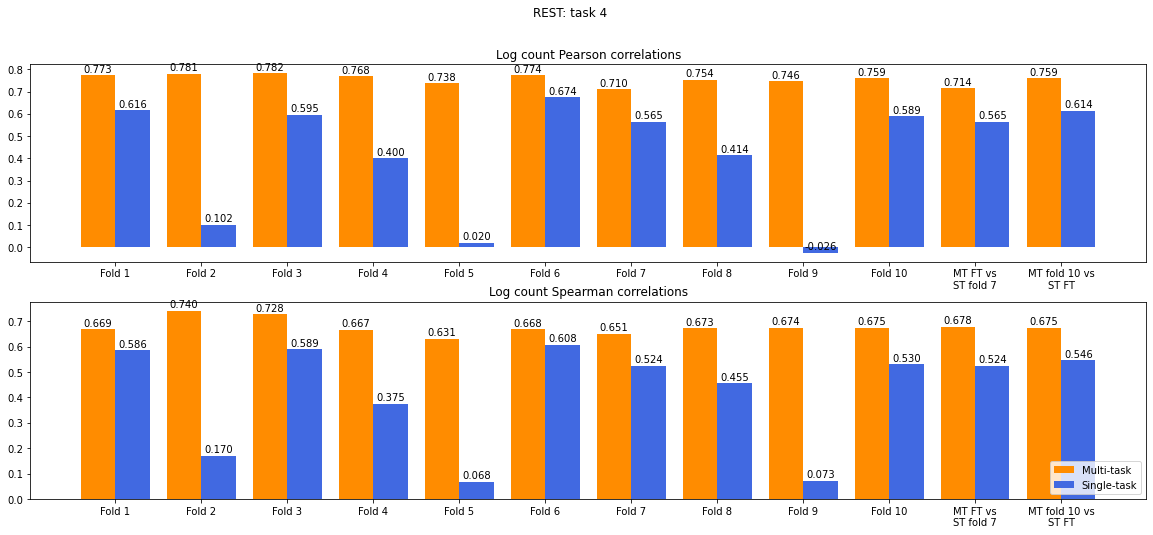

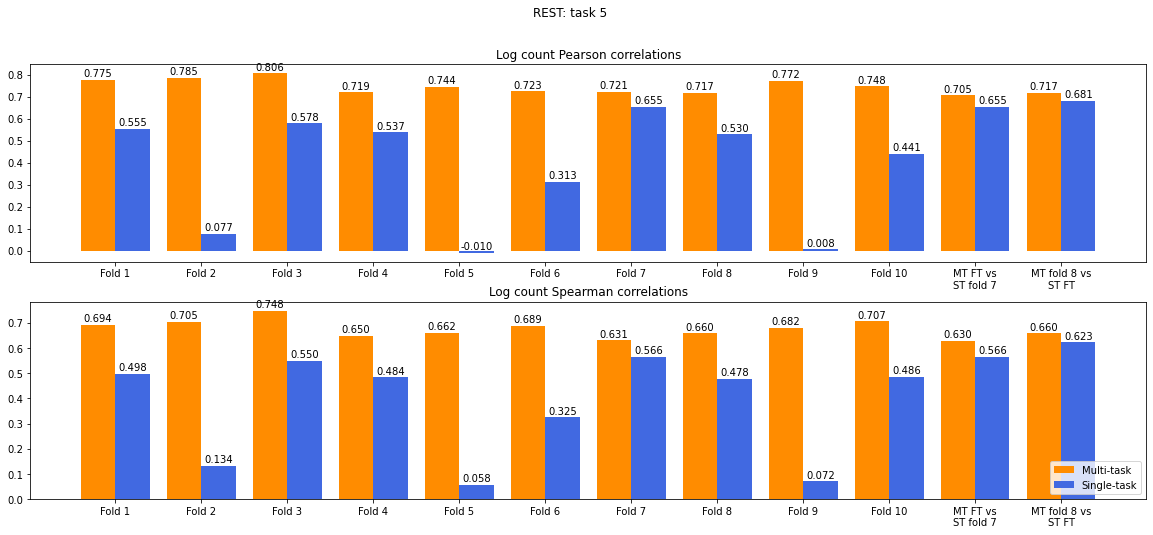

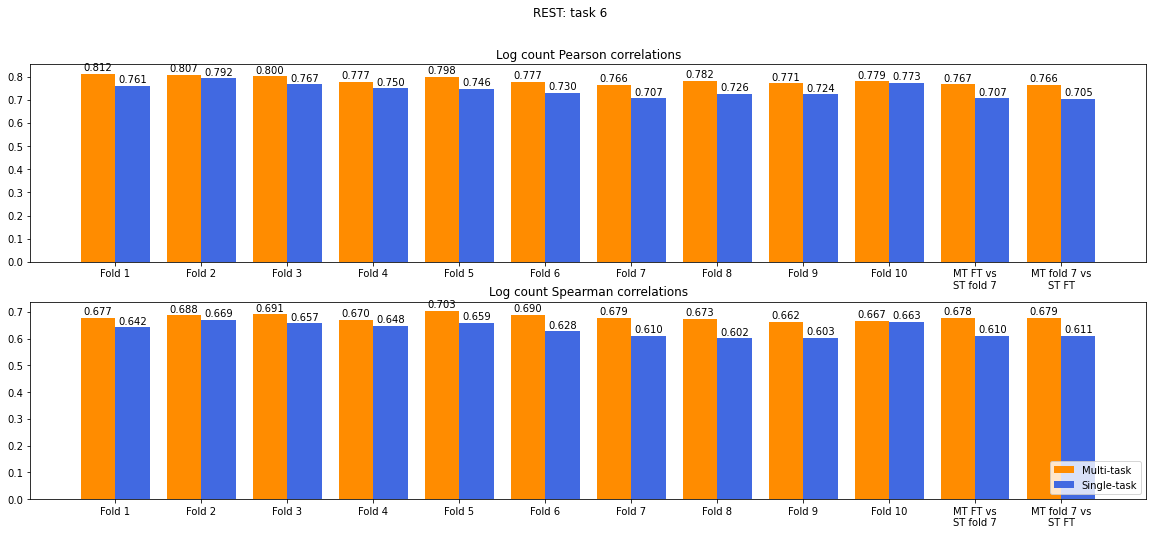

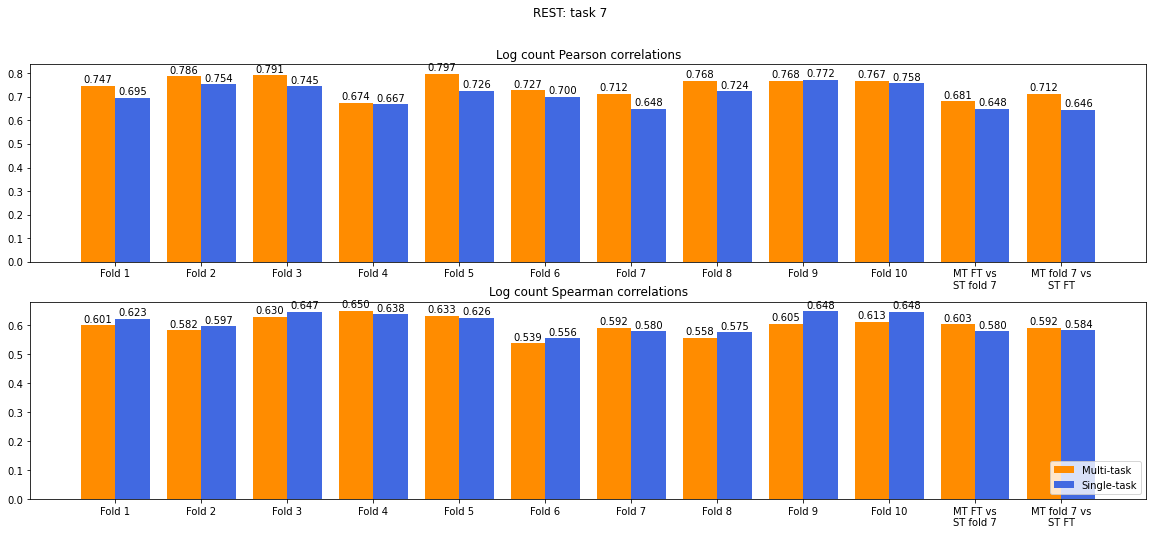

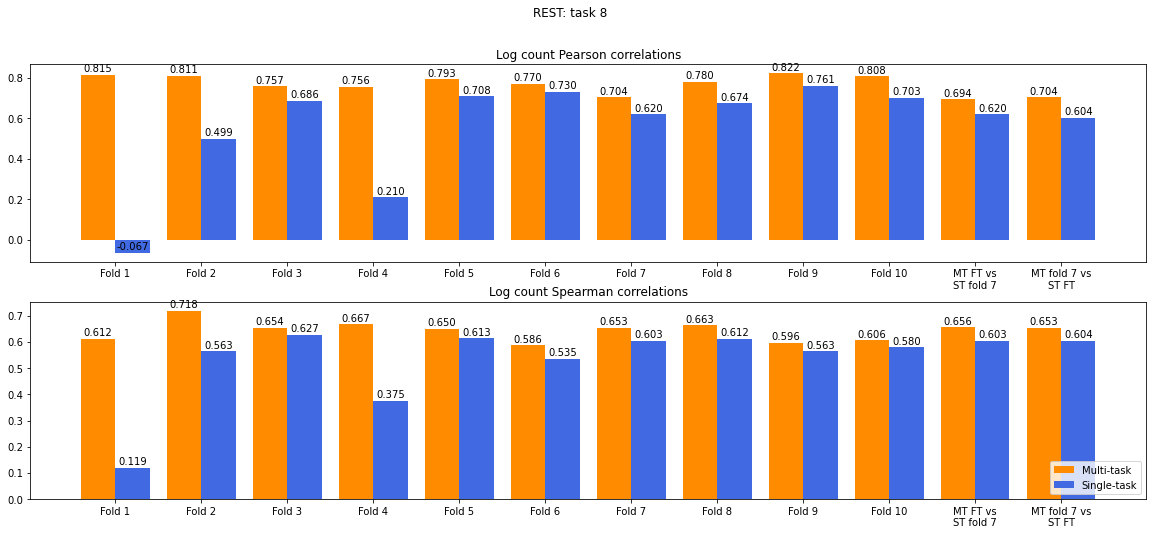

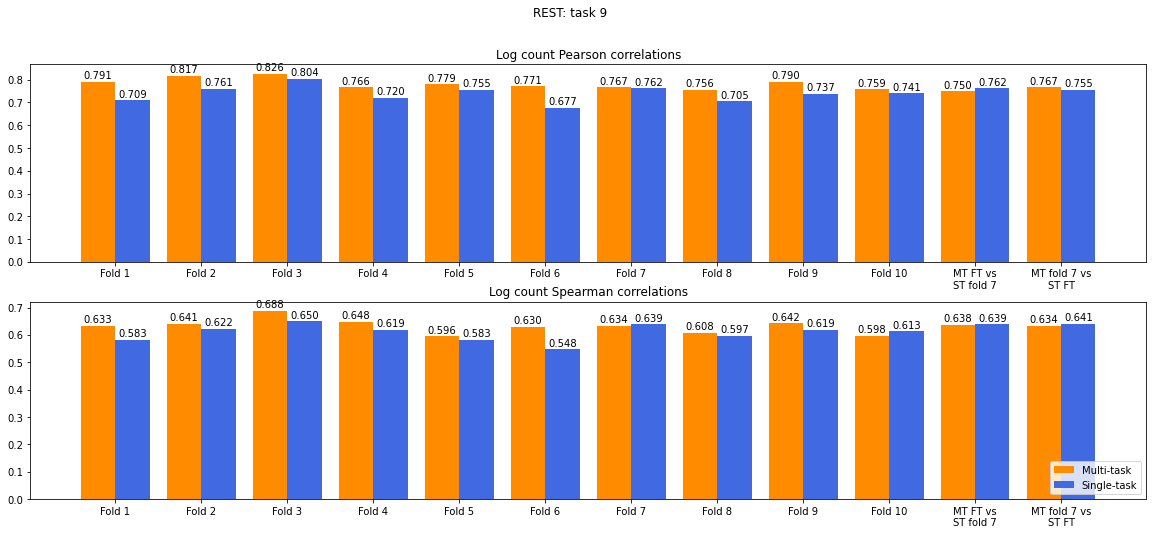

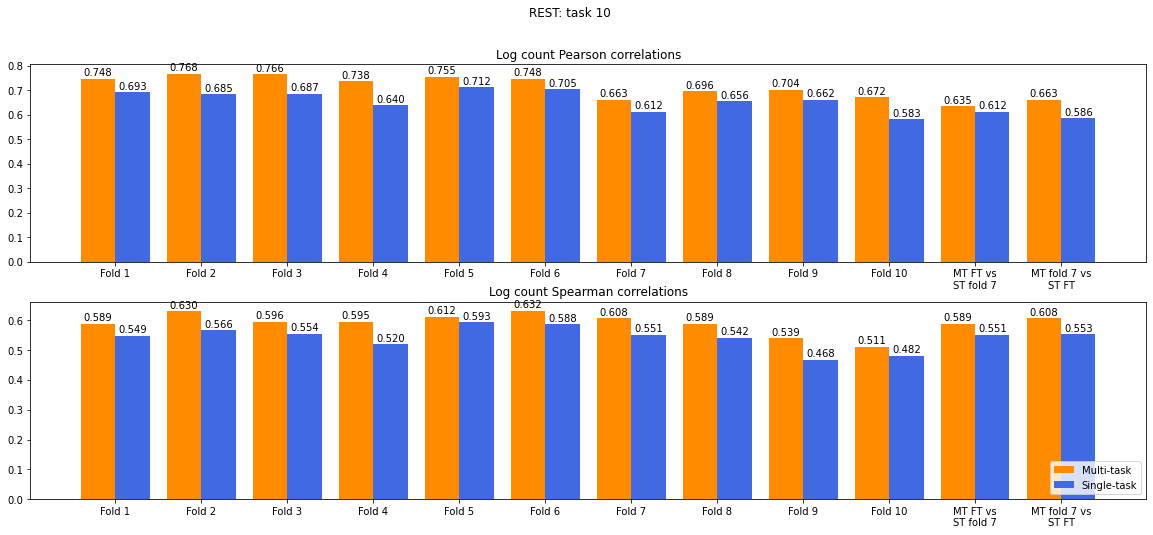

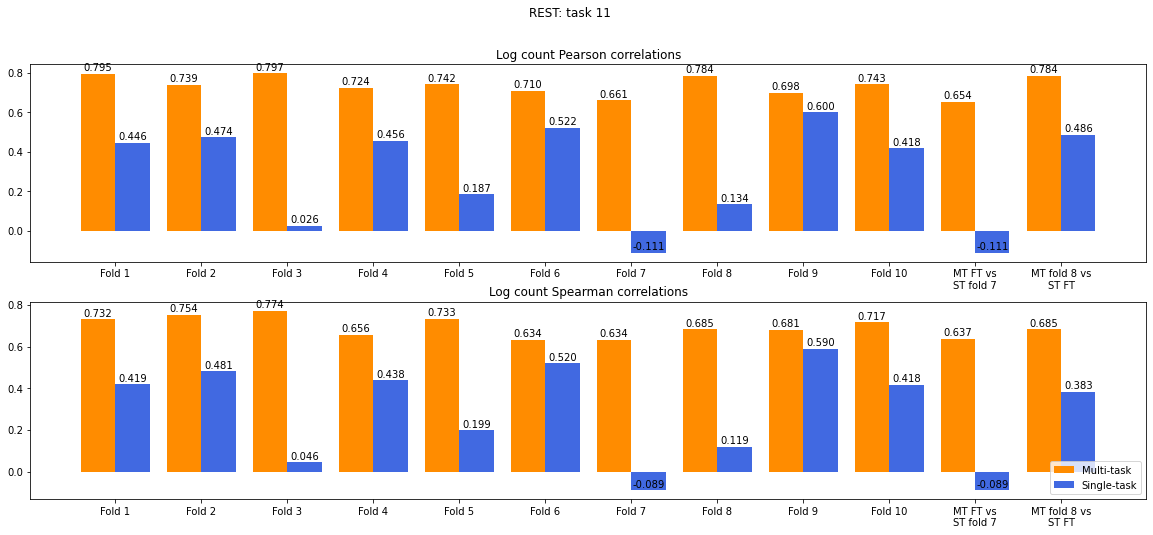

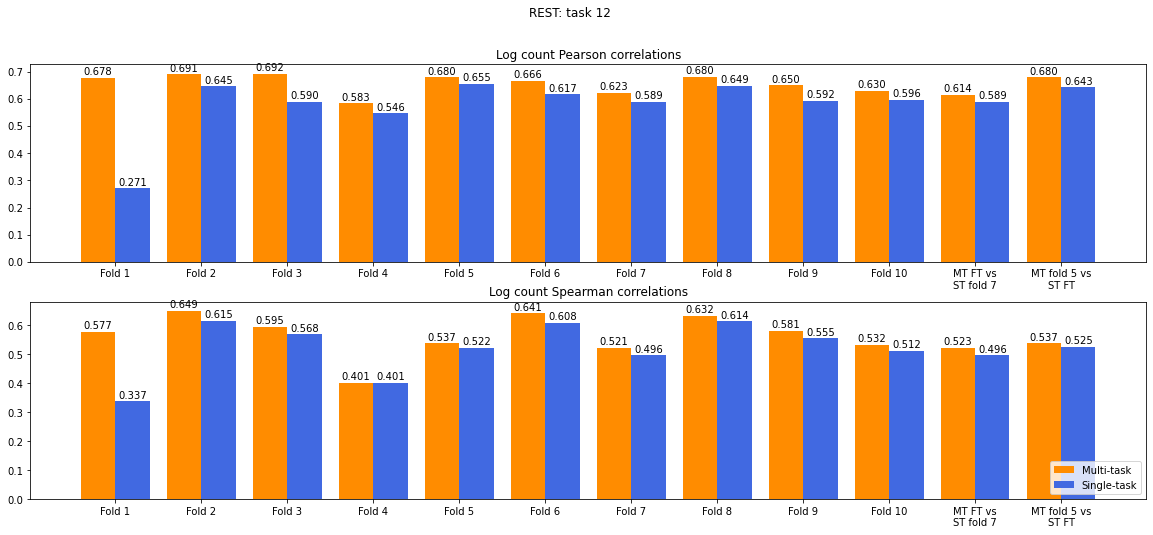

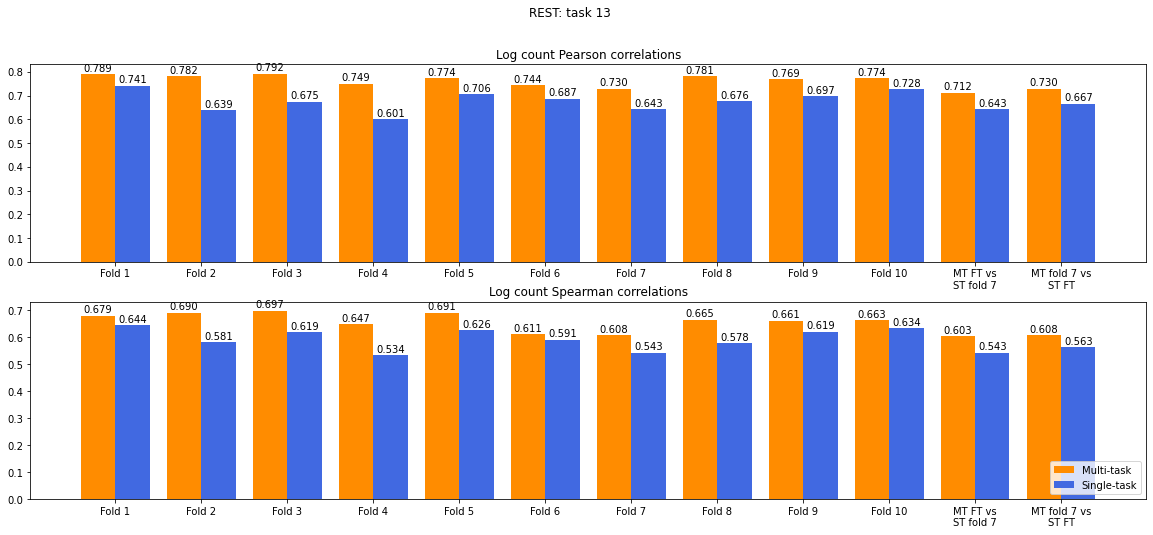

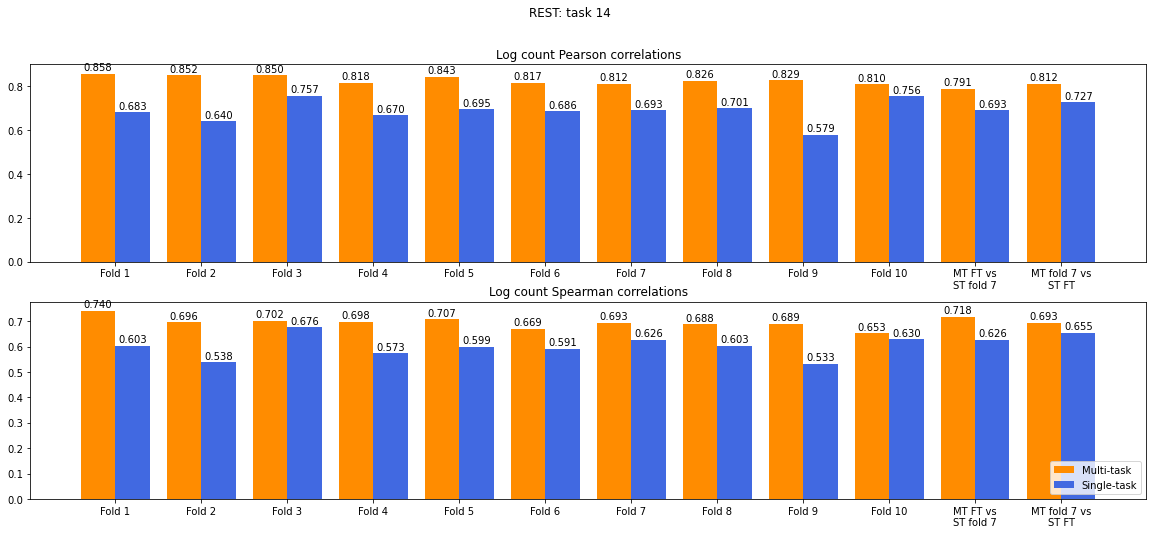

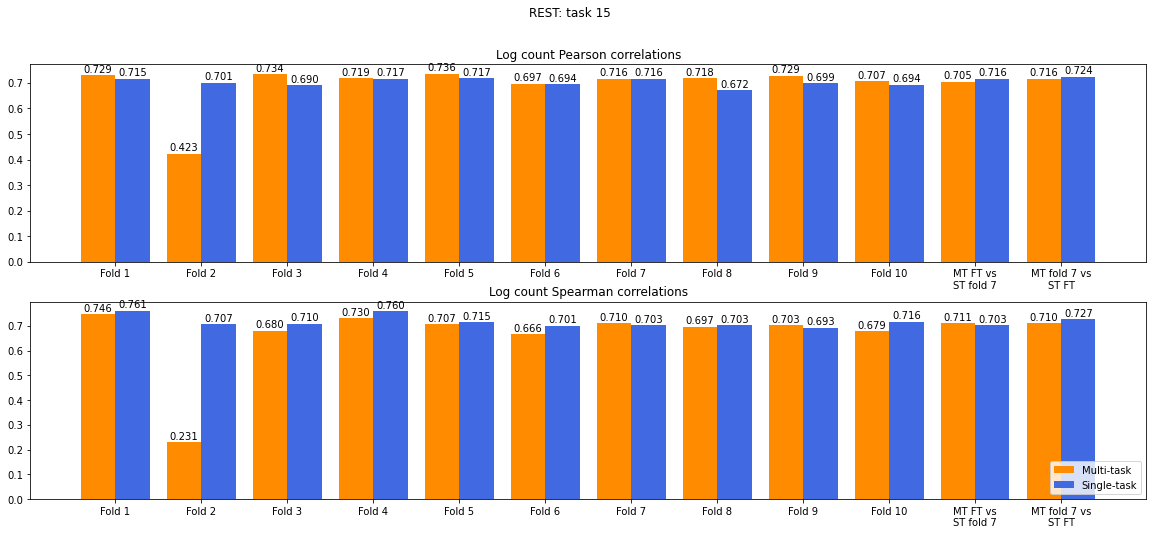

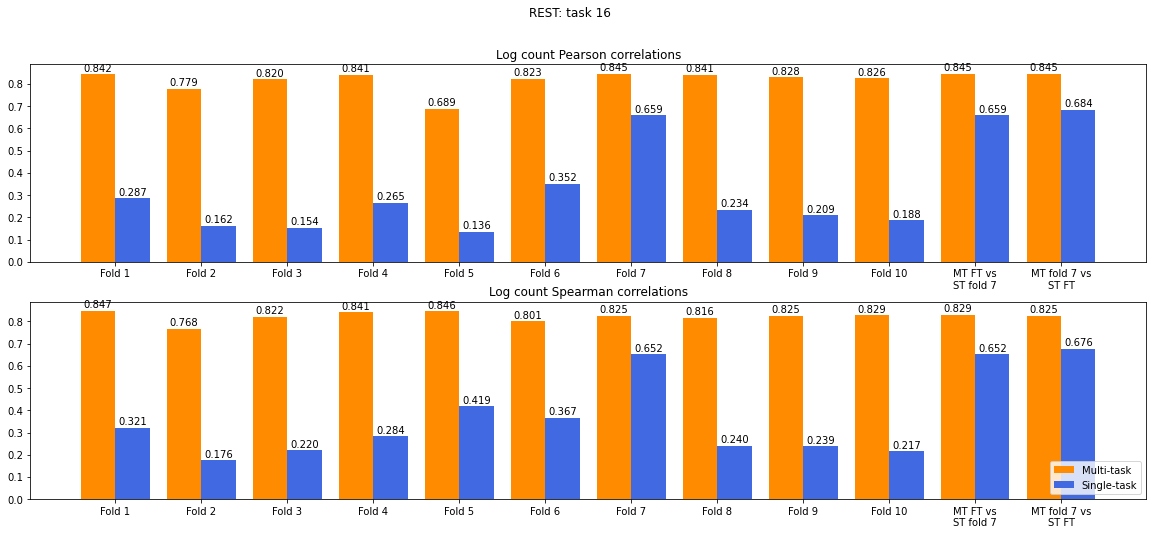

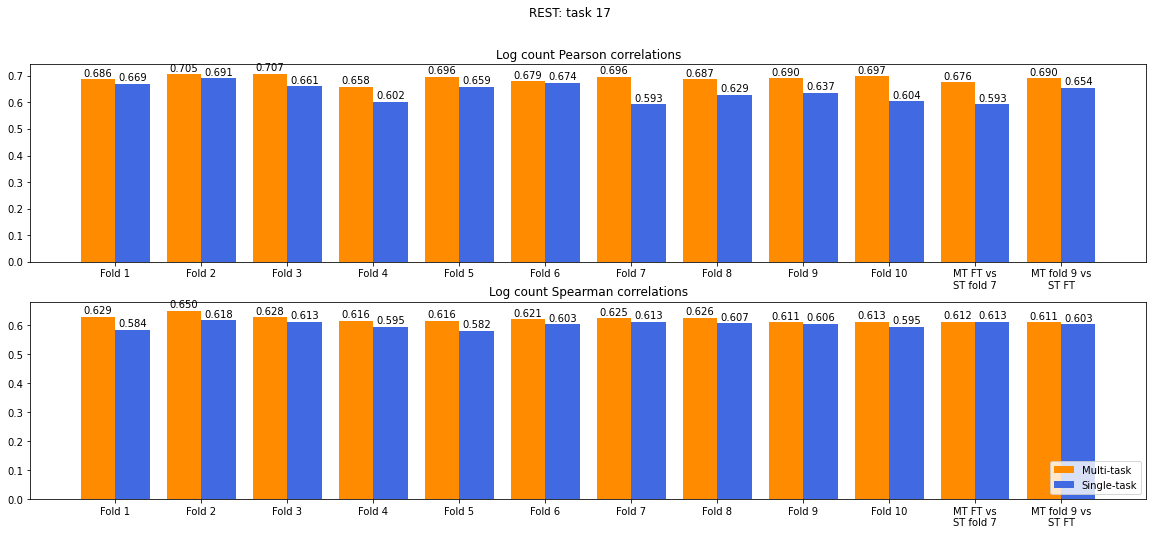

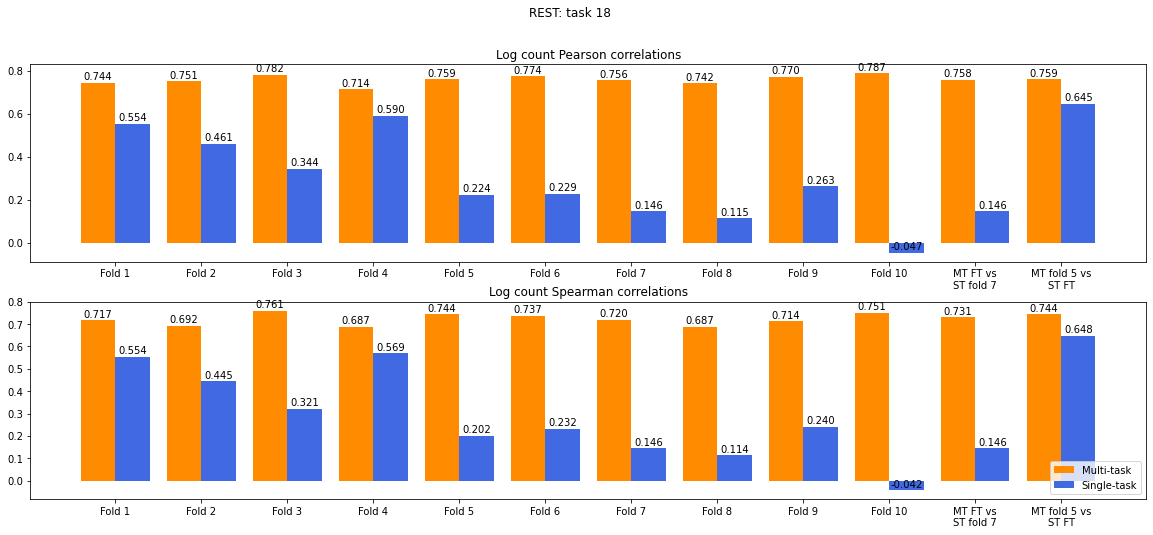

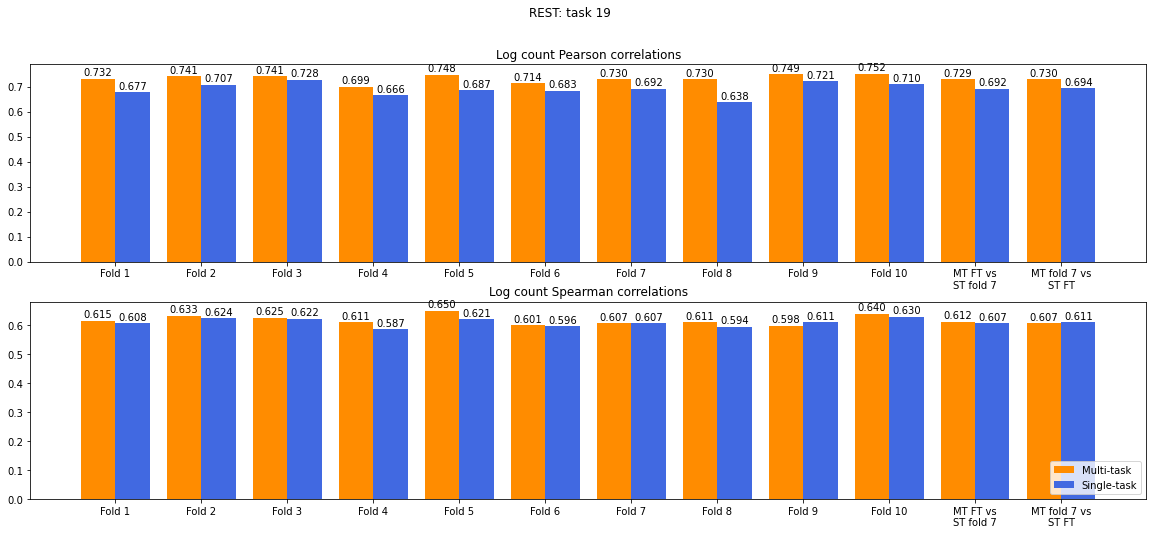

In [10]:
def label_bars(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(
            "%.3f" % height, xy=(bar.get_x() + (bar.get_width() / 2), height),
            xytext=(0, 1), textcoords="offset points", ha="center", va="bottom"
        )

for tf_name in tf_names:
    for task_index in range(num_tasks[tf_name]):
        fig, ax = plt.subplots(nrows=2, figsize=(20, 8))
        
        for i in range(2):
            mt_all_fold_vals = [mt_all_fold_count_corrs[tf_name][fold][task_index][i] for fold in range(1, 11)]
            st_all_fold_vals = [st_all_fold_count_corrs[tf_name][fold][task_index][i] for fold in range(1, 11)]
            mt_best_fold_val = mt_best_fold_count_corrs[tf_name][task_index][i]
            st_best_fold_val = st_best_fold_count_corrs[tf_name][task_index][i]
            
            mt_best_fold = mt_best_folds[tf_name]
            st_best_fold = st_best_folds[tf_name][task_index]
            
            mt_vals = mt_all_fold_vals + [mt_best_fold_val, mt_all_fold_vals[st_best_fold - 1]]
            st_vals = st_all_fold_vals + [st_all_fold_vals[mt_best_fold - 1], st_best_fold_val]
            
            x = np.arange(len(mt_vals))
            width = 0.4
            mt_bars = ax[i].bar(
                x - (width / 2), mt_vals, width=width, color="darkorange", align="center", label="Multi-task"
            )
            st_bars = ax[i].bar(
                x + (width / 2), st_vals, width=width, color="royalblue", align="center", label="Single-task"
            )
            label_bars(ax[i], mt_bars)
            label_bars(ax[i], st_bars)
            
            ax[i].set_xticks(x)
            labels = ["Fold %d" % fold for fold in range(1, 11)]
            labels += ["MT FT vs\nST fold %d" % mt_best_fold]
            labels += ["MT fold %d vs\nST FT" % st_best_fold]
            ax[i].set_xticklabels(labels)
            
        ax[0].set_title("Log count Pearson correlations")
        ax[1].set_title("Log count Spearman correlations")
        fig.suptitle("%s: task %d" % (tf_name, task_index))
        plt.legend(loc="lower right")
        plt.show()
        fig.tight_layout()